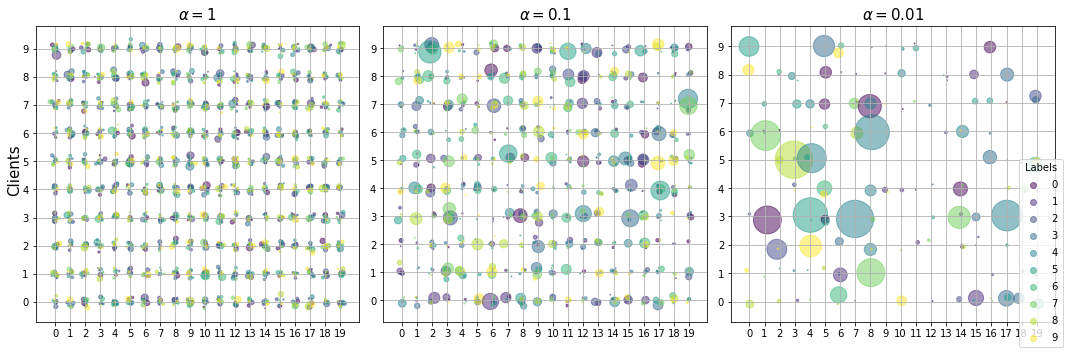

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from collections import Counter
import torch
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from torchvision import datasets
import numpy as np
from data import *
N_CLIENTS = 3400
DIRICHLET_ALPHA = 1

with h5py.File('./data_in_use/femnist.h5', 'r') as f:
    train_data, test_data = f['train'][:], f['test'][:]
    train_data[train_data['label'] < 10]


num_cls = 10

train_labels = np.array(train_data['label'])
client_idcs = dirichlet_split_noniid(
    train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

g = {}
rounds=20
num_clients=10
num_labels=10

fig, ax = plt.subplots(1,3, figsize=(15, 5))
# fig.set_label('aaa')
alpha = [1, 0.1, 0.01]

for f in range(3):
    DIRICHLET_ALPHA = alpha[f]
    # 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
    client_idcs = dirichlet_split_noniid(
        train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
    r = []
    client = []
    label = []
    sample_num = []
    for i in range(rounds):
        np.random.shuffle(client_idcs)
        g = client_idcs[:num_clients]
        for j in range(num_labels):
            for k in range(num_clients):
                cnt=Counter(train_labels[g[k]])
                r += [i]
                label += [j]
                client += [k]
                sample_num += [cnt[j]]
    scale=0.1
    r = np.array(r)+np.random.normal(loc=0.0, scale=scale, size=len(r))
    client = np.array(client)+np.random.normal(loc=0.0, scale=scale, size=len(client))
    scatter=ax[f].scatter(r, client, c=label, s=sample_num, alpha=0.5)
    ax[f].set_xticks(np.arange(rounds))
    ax[f].set_yticks(np.arange(num_cls))
    # ax[f].set_xlabel('communication rounds')
    # ax[f].set_ylabel('Labels')
    ax[f].set_title(r'$\alpha={}$'.format(DIRICHLET_ALPHA),fontsize=15)
    ax[f].grid(True)
fig.legend(*scatter.legend_elements(),
                    loc="lower right", title="Labels")
fig.tight_layout()
# lines, labels = ax[-1].get_legend_handles_labels()

fig.supylabel('Clients',fontsize=15)
# fig.supxlabel('Communication Rounds',fontsize=15)
# fig.legend(legend)
fig.tight_layout()
fig.suptitle('')
fig.subplots_adjust(top=0.9)
fig.savefig('noniid.pdf', bbox_inches='tight')

plt.show()


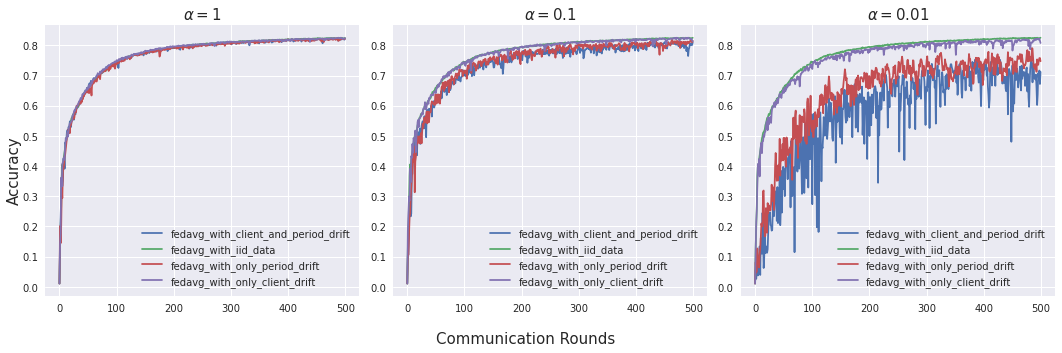

In [3]:
from utils import *
import matplotlib.pyplot as plt
plt.style.use('seaborn')
dataset = 'femnist'
# method='centralized'
table = 'icml_period_client_drift_femnist'
h, l = {}, {}
alpha = [1, 0.1, 0.01]
d = {'method': [],
     'setting': [],
     'acc': []}
agg_loop = ['fedavg', 'fedprox', 'fedavgM',
            'feddf', 'fedmeta', 'pba', 'pba_prox']
iid_loop = ['alpha_1', 'alpha_0.1', 'alpha_0.01']
method = []
setting = []
acc = []
agg = 'fedavg'
iid = 'alpha_0.01'
fig, ax = plt.subplots(1, 3, sharex='col', figsize=(15, 5))
n = 0
nan=0
for iid in iid_loop:
    
    sql = "select * from icml_femnist where dataset='femnist' and method='fedavg' and iid='{}' and local_epochs=1;".format(iid)
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_client_and_period_drift'
    ax[n].plot(h['acc'][:500], label=l)
    
    sql = "select * from icml_period_client_drift_femnist where dataset='femnist' and method='fedavg_period_drift_only' and iid='iid' and local_epochs=1;"
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_iid_data'
    ax[n].plot(h['acc'][:500], label=l)
    
    sql = "select * from icml_period_client_drift_femnist where dataset='femnist' and method='fedavg_period_drift_only' and iid='{}' and local_epochs=1;".format(iid)
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_only_period_drift'
    ax[n].plot(h['acc'][:500], label=l)
    
    sql = "select * from icml_period_client_drift_femnist where dataset='femnist' and method='fedavg_client_drift_only' and iid='{}' and local_epochs=1;".format(iid)
    returns = sql_execute(sql, 'remote')
    h = eval(returns[-1]['recorder'])
    l = 'fedavg_with_only_client_drift'
    ax[n].plot(h['acc'][:500], label=l)
    
    lines, labels = ax[n].get_legend_handles_labels()
    ax[n].legend()
    d['method'] += [agg]
    d['setting'] += [iid]
    d['acc'] += [h['acc'][:500][-1]]
    
    ax[n].set_title(r'$\alpha={}$'.format(alpha[n]),fontsize=15)
    
    
    n+=1
# fig.legend(*scatter.legend_elements(),
#            loc="lower right", title="Labels")
# fig.tight_layout()
# lines, labels = ax[-1].get_legend_handles_labels()

fig.supylabel('Accuracy', fontsize=15)
fig.supxlabel('Communication Rounds', fontsize=15)
# fig.legend(legend)
fig.tight_layout()
fig.suptitle('')
fig.subplots_adjust(top=0.9)
fig.savefig('seperate.pdf', bbox_inches='tight')
results = pd.DataFrame(d)
a = 1


In [13]:
n

3

In [4]:
from utils import *
dataset = 'femnist'
table = 'icml_femnist'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedeve'"]
settings = ["'natural'", "'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
tex = ''
n=100
nan=0
for i in range(len(methods)):
    line = methods[i]
    for iid in settings:
        sql = "select * from {} where dataset like '{}%' and method={} and iid={} and local_epochs=1;".format(table, dataset, methods[i], iid)
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex


"'fedavg' & $0.8243$ & $0.8353$ & $0.8207$ & $0.7332$\\'fedavgm' & $0.8254$ & $0.8366$ & $0.8221$ & $0.7531$\\'fedprox' & $0.8241$ & $0.835$ & $0.8209$ & $0.744$\\'fedopt' & $0.0513$ & $0.8206$ & $0.7839$ & $0.5905$\\'fedeve' & $0.825$ & $0.8306$ & $0.8036$ & $0.6988$\\"

In [6]:
from utils import *
dataset = 'cifar100'
table = 'icml_cifar100'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedeve'"]
settings = ["'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
tex = ''
n=100
nan=0
for i in range(len(methods)):
    line = methods[i]
    for iid in settings:
        sql = "select * from {} where dataset like '{}%' and method={} and iid={} and local_epochs=1;".format(table, dataset, methods[i], iid)
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex

"'fedavg' & $0.468$ & $0.4399$ & $0.291$\\'fedavgm' & $0.2431$ & $0.2103$ & $0.139$\\'fedprox' & $0.4661$ & $0.4386$ & $0.2913$\\'fedopt' & $0.5214$ & $0.5063$ & $0.3487$\\'fedeve' & $0.4301$ & $0.4368$ & $0.2927$\\"

In [31]:
from utils import *
dataset = 'ml-1m'
table = 'icml_ml_1m'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedeve'"]
settings = ["'natural'", "'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
matrics = ['auc', 'hit5', 'hit10', 'ndcg5', 'ndcg10']
tex = ''
n=100
nan=0
for i in range(len(methods)):
    line = methods[i]
    for matric in matrics:
        sql = "select * from {} where dataset like '{}%' and method={} and local_epochs=1;".format(table, dataset, methods[i])
        if 'fedeve' in line:
            sql = "select * from icml_fedeve_ml_1m where dataset like '{}%' and method={} and local_epochs=1;".format(dataset, methods[i])
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])[matric][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex


"'fedavg' & $0.7986$ & $0.2898$ & $0.4359$ & $0.1897$ & $0.2367$\\'fedavgm' & $0.8017$ & $0.2873$ & $0.4421$ & $0.1892$ & $0.239$\\'fedprox' & $0.7615$ & $0.2827$ & $0.431$ & $0.181$ & $0.2288$\\'fedopt' & $0.7994$ & $0.2882$ & $0.4392$ & $0.1907$ & $0.2391$\\'fedeve' & $0.7986$ & $0.2875$ & $0.4399$ & $0.1928$ & $0.2417$\\"

In [1]:
from utils import *
dataset = 'cifar100'
table = 'rebuttal_icml_cifar100'
# tables = ['fedavg', 'fedavgm', 'fedprox',
#           'fedopt', 'fedeve']
methods = ["'fedavg'", "'fedavgm'", "'fedprox'", "'scaffold'",
           "'fedopt'", "'fedeve'"]
settings = ["'alpha_1'", "'alpha_0.1'", "'alpha_0.01'"]
tex = ''
n = 100
nan = 0
for i in range(len(methods)):
    line = methods[i]
    for iid in settings:
        sql = "select * from {} where dataset like '{}%' and method={} and iid={} and local_epochs=1;".format(
            table, dataset, methods[i], iid)
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:])/n
        line += ' & ' + '$'+str(round(acc, 4))+'$'
    line += '\\'
    tex += line
tex


"'fedavg' & $0.4661$ & $0.4428$ & $0.2993$\\'fedavgm' & $0.4858$ & $0.4436$ & $0.3076$\\'fedprox' & $0.4707$ & $0.4394$ & $0.3013$\\'scaffold' & $0.4465$ & $0.4217$ & $0.01$\\'fedopt' & $0.4783$ & $0.4544$ & $0.3054$\\'fedeve' & $0.4815$ & $0.458$ & $0.3209$\\"

In [36]:
from utils import *

# Define variables
dataset = 'cifar100'
table = 'rebuttal_icml_cifar100'
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'scaffold'", "'fedopt'", "'fedeve'"]
settings = {"'alpha_1'": '$\\alpha=1$',
            "'alpha_0.1'": '$\\alpha=0.1$', "'alpha_0.01'": '$\\alpha=0.01$'}
n = 50

# Compute best results for each column
best_accs = [0] * len(settings)
rows = []
for i, method in enumerate(methods):
    row = [f"\\{method[1:-1]}"]
    for j, iid in enumerate(settings):
        sql = f"select * from {table} where dataset like '{dataset}%' and method={method} and iid={iid} and local_epochs=1;"
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:]) / n
        if acc > best_accs[j]:
            best_accs[j] = acc
        row.append(acc)
    rows.append(row)

# Generate table
table_rows = []
for row in rows:
    table_row = [row[0]]
    for j, acc in enumerate(row[1:]):
        if acc == best_accs[j]:
            table_row.append(f"& $\\textbf{{{acc*100:.2f}}}$")
        else:
            table_row.append(f"& {acc*100:.2f}")
    table_row.append("\\\\")
    table_rows.append(" ".join(table_row))

# Combine table elements
tex = (
    "\\begin{table}[]\n"
    "\\centering\n"
    f"\\caption{{Results for {dataset}}}\n"
    f"\\label{{tab:{dataset}}}\n"
    f"\\begin{{tabular}}{{@{{}}l{'c'*len(settings)}@{{}}}}\n"
    "\\toprule\n"
    "Method"
    + " ".join([f"& {setting}" for setting in settings.values()])
    + " \\\\ \n"
    "\\midrule\n"
    + "\n".join(table_rows)
    + "\n\\bottomrule\n"
    "\\end{tabular}\n"
    "\\end{table}"
)

# Print table
print(tex)


NameError: name 'nan' is not defined

In [53]:
from utils import *

# Define variables
dataset = 'femnist'
table = 'rebuttal_icml_femnist'
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'scaffold'", "'fedopt'", "'fedeve'"]
settings = {"'natural'": 'natural', "'alpha_1'": '$\\alpha=1$',
            "'alpha_0.1'": '$\\alpha=0.1$', "'alpha_0.01'": '$\\alpha=0.01$'}
n = 50

# Compute best results for each column
best_accs = [0] * len(settings)
rows = []
for i, method in enumerate(methods):
    row = [f"\\{method[1:-1]}"]
    for j, iid in enumerate(settings):
        sql = f"select * from {table} where dataset like '{dataset}%' and method={method} and iid={iid} and local_epochs=1;"
        returns = sql_execute(sql, 'remote')
        acc = sum(eval(returns[-1]['recorder'])['acc'][-n:]) / n
        if acc > best_accs[j]:
            best_accs[j] = acc
        row.append(acc)
    rows.append(row)

# Generate table
table_rows = []
for row in rows:
    table_row = [row[0]]
    for j, acc in enumerate(row[1:]):
        if acc == best_accs[j]:
            table_row.append(f"& $\\textbf{{{acc*100:.2f}}}$")
        else:
            table_row.append(f"& {acc*100:.2f}")
    table_row.append("\\\\")
    table_rows.append(" ".join(table_row))

# Combine table elements
tex = (
    "\\begin{table}[]\n"
    "\\centering\n"
    f"\\caption{{Results for {dataset}}}\n"
    f"\\label{{tab:{dataset}}}\n"
    f"\\begin{{tabular}}{{@{{}}l{'c'*len(settings)}@{{}}}}\n"
    "\\toprule\n"
    "Method"
    + " ".join([f"& {setting}" for setting in settings.values()])
    + " \\\\ \n"
    "\\midrule\n"
    + "\n".join(table_rows)
    + "\n\\bottomrule\n"
    "\\end{tabular}\n"
    "\\end{table}"
)

# Print table
print(tex)


\begin{table}[]
\centering
\caption{Results for femnist}
\label{tab:femnist}
\begin{tabular}{@{}lcccc@{}}
\toprule
Method& natural & $\alpha=1$ & $\alpha=0.1$ & $\alpha=0.01$ \\ 
\midrule
\fedavg & 82.20 & 83.64 & 82.22 & 72.23 \\
\fedavgm & 82.49 & 83.69 & 82.54 & 73.59 \\
\fedprox & 82.18 & 83.61 & 82.25 & 73.47 \\
\scaffold & 5.13 & 83.11 & 5.13 & 5.13 \\
\fedopt & 5.13 & 82.01 & 78.87 & 5.13 \\
\fedeve & $\textbf{82.54}$ & $\textbf{83.84}$ & $\textbf{82.77}$ & $\textbf{74.08}$ \\
\bottomrule
\end{tabular}
\end{table}


In [64]:
from utils import *
import numpy as np

# Define variables
dataset = 'femnist'
table = 'rebuttal_icml_femnist'
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'scaffold'", "'fedopt'", "'fedeve'"]
settings = {"'natural'": 'natural', "'alpha_1'": '$\\alpha=1$',
            "'alpha_0.1'": '$\\alpha=0.1$', "'alpha_0.01'": '$\\alpha=0.01$'}
n = 50
repeats = 5

# Compute mean and standard deviation for each cell
means = np.zeros((len(methods), len(settings)))
stds = np.zeros((len(methods), len(settings)))
for i, method in enumerate(methods):
    for j, iid in enumerate(settings):
        accs = []
        sql = f"select * from {table} where dataset like '{dataset}%' and method={method} and iid={iid} and local_epochs=1;"
        returns = sql_execute(sql, 'remote')
        for r in range(repeats):
            if r >= len(returns):
                break  # Skip if there are not enough results for this setting and method
            acc = sum(eval(returns[-1-r]['recorder'])['acc'][-n:]) / n
            accs.append(acc)
        if len(accs) > 0:
            means[i, j] = np.mean(accs)
            stds[i, j] = np.std(accs)


# Generate table
table_rows = []
for i, method in enumerate(methods):
    row = [f"\\{method[1:-1]}"]
    for j, iid in enumerate(settings):
        if np.isclose(means[i, j], np.max(means[:, j])):
            row.append(
                f"\\textbf{{{means[i, j]*100:.2f} $\\pm$ {stds[i, j]*100:.2f}}}")
        else:
            row.append(f"{means[i, j]*100:.2f} $\\pm$ {stds[i, j]*100:.2f}")
    table_rows.append(row)

# Combine table elements
tex = (
    "\\begin{table}[]\n"
    "\\centering\n"
    f"\\caption{{Results for {dataset}}}\n"
    f"\\label{{tab:{dataset}}}\n"
    "\\resizebox{1\\linewidth}{!}{"
    f"\\begin{{tabular}}{{@{{}}l{'c'*len(settings)}@{{}}}}\n"
    "\\toprule\n"
    "Method"
    + " ".join([f"& {setting}" for setting in settings.values()])
    + " \\\\ \n"
    "\\midrule\n"
    + "\n".join([" & ".join(row) + " \\\\" for row in table_rows])
    + "\n\\bottomrule\n"
    "\\end{tabular}"
    "}\n"
    "\\end{table}"
)


# Print table
print(tex)


\begin{table}[]
\centering
\caption{Results for femnist}
\label{tab:femnist}
\resizebox{1\linewidth}{!}{\begin{tabular}{@{}lcccc@{}}
\toprule
Method& natural & $\alpha=1$ & $\alpha=0.1$ & $\alpha=0.01$ \\ 
\midrule
\fedavg & 82.37 $\pm$ 0.10 & 83.60 $\pm$ 0.04 & 82.02 $\pm$ 0.16 & 73.23 $\pm$ 1.26 \\
\fedavgm & 82.53 $\pm$ 0.15 & 83.68 $\pm$ 0.04 & 82.30 $\pm$ 0.13 & 74.96 $\pm$ 1.25 \\
\fedprox & 82.34 $\pm$ 0.10 & 83.58 $\pm$ 0.04 & 82.04 $\pm$ 0.15 & 74.16 $\pm$ 0.98 \\
\scaffold & 5.13 $\pm$ 0.00 & 83.06 $\pm$ 0.08 & 48.91 $\pm$ 35.75 & 5.13 $\pm$ 0.00 \\
\fedopt & 5.13 $\pm$ 0.00 & 82.06 $\pm$ 0.08 & 78.27 $\pm$ 0.38 & 16.66 $\pm$ 23.06 \\
\fedeve & \textbf{82.68 $\pm$ 0.08} & \textbf{83.80 $\pm$ 0.04} & \textbf{82.63 $\pm$ 0.11} & \textbf{75.03 $\pm$ 1.13} \\
\bottomrule
\end{tabular}}
\end{table}


In [88]:
from utils import *
import numpy as np

# Define variables
dataset = 'cifar100'
table = 'rebuttal_icml_cifar100'
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'scaffold'", "'fedopt'", "'fedeve'"]
settings = {"'alpha_1'": '$\\alpha=1$',
            "'alpha_0.1'": '$\\alpha=0.1$', "'alpha_0.01'": '$\\alpha=0.01$'}
n = 100
repeats = 5

# Compute mean and standard deviation for each cell
means = np.zeros((len(methods), len(settings)))
stds = np.zeros((len(methods), len(settings)))
for i, method in enumerate(methods):
    for j, iid in enumerate(settings):
        accs = []
        sql = f"select * from {table} where dataset like '{dataset}%' and method={method} and iid={iid} and local_epochs=1;"
        returns = sql_execute(sql, 'remote')
        for r in range(repeats):
            if r >= len(returns):
                break  # Skip if there are not enough results for this setting and method
            acc = sum(eval(returns[-1-r]['recorder'])['acc'][-n:]) / n
            accs.append(acc)
        if len(accs) > 0:
            means[i, j] = np.mean(accs)
            stds[i, j] = np.std(accs)


# Generate table
table_rows = []
for i, method in enumerate(methods):
    row = [f"\\{method[1:-1]}"]
    for j, iid in enumerate(settings):
        if np.isclose(means[i, j], np.max(means[:, j])):
            row.append(
                f"\\textbf{{{means[i, j]*100:.2f} $\\pm$ {stds[i, j]*100:.2f}}}")
        else:
            row.append(f"{means[i, j]*100:.2f} $\\pm$ {stds[i, j]*100:.2f}")
    table_rows.append(row)

# Combine table elements
tex = (
    "\\begin{table}[]\n"
    "\\centering\n"
    f"\\caption{{Results for {dataset}}}\n"
    f"\\label{{tab:{dataset}}}\n"
    "\\resizebox{1\\linewidth}{!}{"
    f"\\begin{{tabular}}{{@{{}}l{'c'*len(settings)}@{{}}}}\n"
    "\\toprule\n"
    "Method"
    + " ".join([f"& {setting}" for setting in settings.values()])
    + " \\\\ \n"
    "\\midrule\n"
    + "\n".join([" & ".join(row) + " \\\\" for row in table_rows])
    + "\n\\bottomrule\n"
    "\\end{tabular}"
    "}\n"
    "\\end{table}"
)


# Print table
print(tex)


\begin{table}[]
\centering
\caption{Results for cifar100}
\label{tab:cifar100}
\resizebox{1\linewidth}{!}{\begin{tabular}{@{}lccc@{}}
\toprule
Method& $\alpha=1$ & $\alpha=0.1$ & $\alpha=0.01$ \\ 
\midrule
\fedavg & 47.12 $\pm$ 0.30 & 43.92 $\pm$ 0.25 & 29.88 $\pm$ 0.62 \\
\fedavgm & 48.32 $\pm$ 0.18 & 44.73 $\pm$ 0.41 & 31.37 $\pm$ 1.07 \\
\fedprox & 46.98 $\pm$ 0.28 & 43.74 $\pm$ 0.14 & 29.84 $\pm$ 0.62 \\
\scaffold & 45.21 $\pm$ 0.41 & 36.35 $\pm$ 5.27 & 1.00 $\pm$ 0.00 \\
\fedopt & 47.37 $\pm$ 1.27 & \textbf{47.68 $\pm$ 1.17} & 32.07 $\pm$ 1.29 \\
\fedeve & \textbf{48.50 $\pm$ 0.26} & 45.64 $\pm$ 0.18 & \textbf{32.50 $\pm$ 0.67} \\
\bottomrule
\end{tabular}}
\end{table}


In [89]:
from utils import *

# Define variables
dataset = 'ml-1m'
table = 'rebuttal_icml_ml_1m'
methods = ["'fedavg'", "'fedavgm'", "'fedprox'",
           "'fedopt'", "'fedeve'"]
metrics = ['auc', 'hit5', 'hit10', 'ndcg5', 'ndcg10']
n = 100
num_repeats = 5

# Compute results for each run
all_results = []
for repeat in range(num_repeats):
    results = {}
    for method in methods:
        method_results = {}
        for metric in metrics:
            if method == "'fedeve'":
                sql = f"select * from {table} where dataset like '{dataset}%' and method={method} and local_epochs=1;"
                returns = sql_execute(sql, 'remote')
                recorder = eval(returns[-1-repeat]['recorder'])
                best_val = max(recorder[metric])
                method_results[metric] = best_val
            else:
                sql = f"select * from {table} where dataset like '{dataset}%' and method={method} and local_epochs=1;"
                returns = sql_execute(sql, 'remote')
                acc = sum(eval(returns[-1-repeat]['recorder'])[metric][-n:]) / n
                method_results[metric] = acc
        results[method] = method_results
    all_results.append(results)


# Compute mean and std of each metric for each method
mean_results = {}
for method in methods:
    method_results = {}
    for metric in metrics:
        metric_results = [results[method][metric] for results in all_results]
        mean = sum(metric_results) / num_repeats
        std = (sum([(r - mean)**2 for r in metric_results]) /
               (num_repeats - 1))**0.5
        method_results[metric] = (mean, std)
    mean_results[method] = method_results

# Generate table
table_rows = []
for method in methods:
    row = [f"\\{method[1:-1]}"]
    for metric in metrics:
        mean, std = mean_results[method][metric]
        if mean == max([mean_results[m][metric][0] for m in methods]):
            row.append(f"& \\textbf{{{mean:.4f} $\\pm$ {std:.4f}}}")
        else:
            row.append(f"& {mean:.4f} $\\pm$ {std:.4f}")
    row.append("\\\\")
    table_rows.append(" ".join(row))

# Generate table
table_rows = []
for method in methods:
    row = [f"\\{method[1:-1]}"]
    for metric in metrics:
        mean, std = mean_results[method][metric]
        if mean == max([mean_results[m][metric][0] for m in methods]):
            row.append(f"& \\textbf{{{mean:.4f} $\\pm$ {std:.4f}}}")
        else:
            row.append(f"& {mean:.4f} $\\pm$ {std:.4f}")
    row.append("\\\\")
    table_rows.append(" ".join(row))

# Combine table elements and resize the table
tex = (
    "\\begin{table}[h]\n"
    "\\centering\n"
    f"\\caption{{Results for {dataset} (mean $\\pm$ std over {num_repeats} runs)}}\n"
    f"\\label{{tab:{dataset}}}\n"
    f"\\resizebox{{1\\linewidth}}{{!}} {{"
    f"\\begin{{tabular}}{{@{{}}l{'c'*len(metrics)}@{{}}}}\n"
    "\\toprule\n"
    "Method"
    + " ".join([f"& {metric}" for metric in metrics])
    + " \\\\ \n"
    "\\midrule\n"
    + "\n".join(table_rows)
    + "\n\\bottomrule\n"
    "\\end{tabular}}\n"
    "\\end{table}"
)

# Print table
print(tex)


\begin{table}[h]
\centering
\caption{Results for ml-1m (mean $\pm$ std over 5 runs)}
\label{tab:ml-1m}
\resizebox{1\linewidth}{!} {\begin{tabular}{@{}lccccc@{}}
\toprule
Method& auc & hit5 & hit10 & ndcg5 & ndcg10 \\ 
\midrule
\fedavg & 0.7958 $\pm$ 0.0016 & 0.2878 $\pm$ 0.0073 & 0.4394 $\pm$ 0.0069 & 0.1898 $\pm$ 0.0034 & 0.2381 $\pm$ 0.0031 \\
\fedavgm & 0.7975 $\pm$ 0.0019 & 0.2928 $\pm$ 0.0154 & 0.4444 $\pm$ 0.0110 & 0.1929 $\pm$ 0.0104 & 0.2407 $\pm$ 0.0098 \\
\fedprox & \textbf{0.8037 $\pm$ 0.0009} & \textbf{0.2959 $\pm$ 0.0032} & \textbf{0.4507 $\pm$ 0.0020} & \textbf{0.1952 $\pm$ 0.0034} & \textbf{0.2441 $\pm$ 0.0029} \\
\fedopt & 0.7943 $\pm$ 0.0032 & 0.2943 $\pm$ 0.0070 & 0.4458 $\pm$ 0.0092 & 0.1935 $\pm$ 0.0038 & 0.2414 $\pm$ 0.0037 \\
\fedeve & 0.7967 $\pm$ 0.0016 & 0.2916 $\pm$ 0.0077 & 0.4460 $\pm$ 0.0088 & 0.1924 $\pm$ 0.0039 & 0.2407 $\pm$ 0.0037 \\
\bottomrule
\end{tabular}}
\end{table}


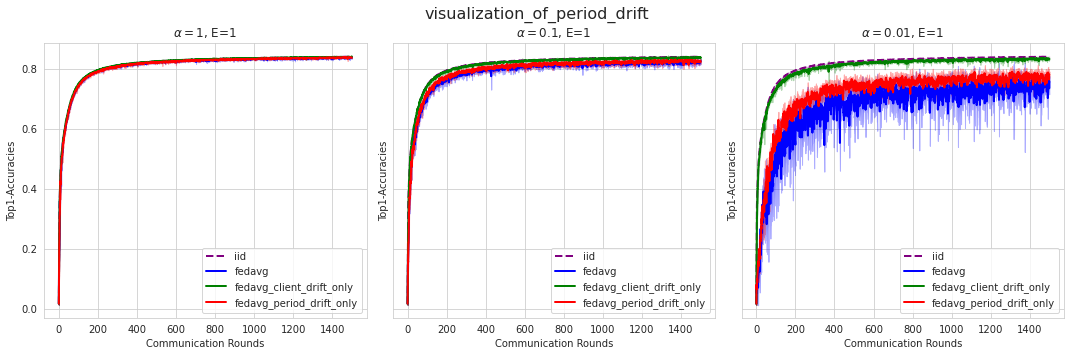

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 读取CSV文件
df = pd.read_csv('nips_2023_rebuttal_period_client_drift_femnist.csv')

# 2. 提取需要的列：'seed', 'iid', 'local_epochs', 'method', 'recorder'
df = df[['seed', 'iid', 'local_epochs', 'method', 'recorder']]

# 将 'nan' 字符串替换为 numpy 的 nan，以便正确地评估
df['recorder'] = df['recorder'].str.replace('nan', 'np.nan')

# 3. 舍弃包含NaN值的记录：检查'recorder'列中的'loss'是否包含NaN，并舍弃这些行
df = df[df['recorder'].apply(lambda x: 'loss' in eval(x) and not any(pd.isna(eval(x)['loss'])))]

# 4. 初始化绘图设置
iid_settings = ['alpha_1', 'alpha_0.1', 'alpha_0.01']
# local_epochs_settings = [1, 3, 5]
local_epochs_settings = [1]
methods = ['fedavg', 'fedavg_client_drift_only', 'fedavg_period_drift_only']

# 设置Seaborn风格
sns.set_style("whitegrid")
sns.set_palette("deep")

# 为每种组合创建子图，调换行和列
# fig, axes = plt.subplots(len(local_epochs_settings), len(iid_settings), figsize=(18, 10), sharex=True, sharey=True)
fig, axes = plt.subplots(len(local_epochs_settings), len(iid_settings), figsize=(15, 5), sharex=True, sharey=True)

# 定义一个新颜色用于iid的情况
color_map = {
    'fedavg': 'blue',
    'fedavg_client_drift_only': 'green',
    'fedavg_period_drift_only': 'red',
    'iid': 'purple'
}
alpha={'natural':r"natural",'alpha_1':r"$\alpha=1$",'alpha_0.1':r"$\alpha=0.1$",'alpha_0.01':r"$\alpha=0.01$"}

# 设置 matplotlib 支持 LaTeX
# plt.rc('text', usetex=True)

# 5. 对于每种local_epochs、iid和method的组合，计算平均值和标准差，并绘制曲线及其置信区间
for j, iid_setting in enumerate(iid_settings):
    for i, local_epoch in enumerate(local_epochs_settings):
        # ax = axes[i, j]
        ax = axes[j]
        
        # 先绘制iid的情况
        subset_iid = df[(df['iid'] == 'iid') & (df['local_epochs'] == local_epoch)]
        if not subset_iid.empty:
            acc_values_iid = subset_iid['recorder'].apply(lambda x: eval(x)['acc']).tolist()
            mean_acc_iid = np.mean(acc_values_iid, axis=0)[:]  # 只取前500个数据点
            std_acc_iid = np.std(acc_values_iid, axis=0)[:]
            epochs_iid = range(len(mean_acc_iid))
            
            ax.plot(epochs_iid, mean_acc_iid, label='iid', color=color_map['iid'], linewidth=2, linestyle='--')
            ax.fill_between(epochs_iid, mean_acc_iid-std_acc_iid, mean_acc_iid+std_acc_iid, color=color_map['iid'], alpha=0.2)

        # 接着绘制其他三种方法的曲线
        for method in methods:
            subset = df[(df['iid'] == iid_setting) & (df['local_epochs'] == local_epoch) & (df['method'] == method)]
            if not subset.empty:
                acc_values = subset['recorder'].apply(lambda x: eval(x)['acc']).tolist()
                mean_acc = np.mean(acc_values, axis=0)[:]  # 只取前500个数据点
                std_acc = np.std(acc_values, axis=0)[:]
                epochs = range(len(mean_acc))
                
                ax.plot(epochs, mean_acc, label=method, color=color_map[method], linewidth=2)
                ax.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)

        # 设置子图的标题、横纵坐标标签、图例
        ax.set_title(alpha[iid_setting]+ r", E={}".format(local_epoch))
        ax.set_xlabel("Communication Rounds", fontsize=10)
        ax.set_ylabel("Top1-Accuracies", fontsize=10)
        ax.legend(frameon=True)

# 调整图形的布局和标题
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.suptitle("visualization_of_period_drift", fontsize=16)
plt.show()
fig.savefig('visualization_of_period_drift.pdf', bbox_inches='tight')


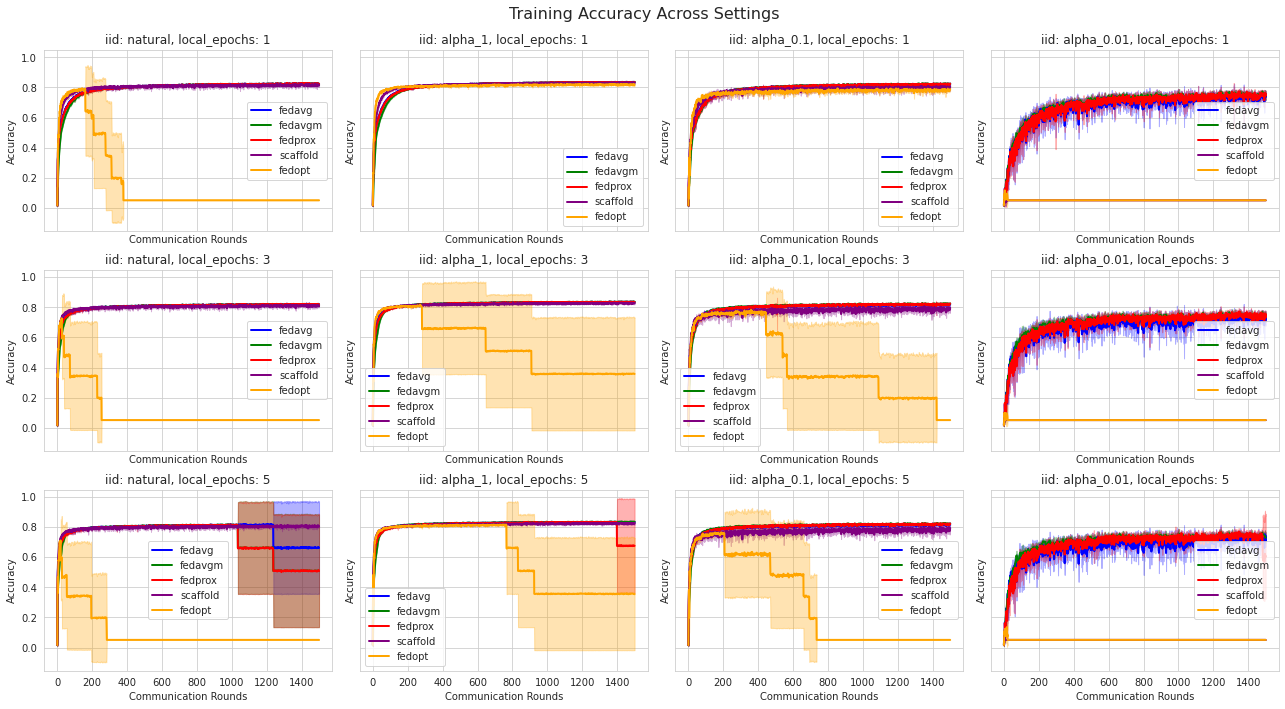

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 读取CSV文件
df = pd.read_csv('nips_2023_rebuttal_different_local_epochs_femnist.csv')
df['recorder'] = df['recorder'].str.replace('nan', 'np.nan')
# 2. 提取所需的列并处理recorder列
df['recorder'] = df['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df['acc_list'] = df['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_relevant = df[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]
df_relevant = df_relevant[df_relevant['acc_list'].notnull()]

# 3. Initialize plotting settings
sns.set_style("whitegrid")
sns.set_palette("deep")
color_map = {
    'fedavg': 'blue',
    'fedavgm': 'green',
    'fedprox': 'red',
    'scaffold': 'purple',
    'fedopt': 'orange'
}
iid_settings = ["natural", "alpha_1", "alpha_0.1", "alpha_0.01"]
local_epochs_settings = [1, 3, 5]
methods = ["fedavg", "fedavgm", "fedprox", "scaffold", "fedopt"]

# 4. Create subplots and plot data
fig, axes = plt.subplots(len(local_epochs_settings), len(iid_settings), figsize=(18, 10), sharex=True, sharey=True)
for j, iid_setting in enumerate(iid_settings):
    for i, local_epoch in enumerate(local_epochs_settings):
        ax = axes[i, j]
        for method in methods:
            subset = df_relevant[(df_relevant['iid'] == iid_setting) & 
                                 (df_relevant['local_epochs'] == local_epoch) & 
                                 (df_relevant['method'] == method)]
            if not subset.empty:
                acc_values = list(subset['acc_list'])
                mean_acc = np.mean(acc_values, axis=0)
                std_acc = np.std(acc_values, axis=0)
                epochs = range(len(mean_acc))
                ax.plot(epochs, mean_acc, label=method, color=color_map[method], linewidth=2)
                ax.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)
        ax.set_title(f"iid: {iid_setting}, local_epochs: {local_epoch}")
        ax.set_xlabel("Communication Rounds", fontsize=10)
        ax.set_ylabel("Accuracy", fontsize=10)
        ax.legend(frameon=True)

# 5. Adjust layout and title
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Training Accuracy Across Settings", fontsize=16)
plt.show()
fig.savefig('training_accuracy_across_settings.pdf', bbox_inches='tight')


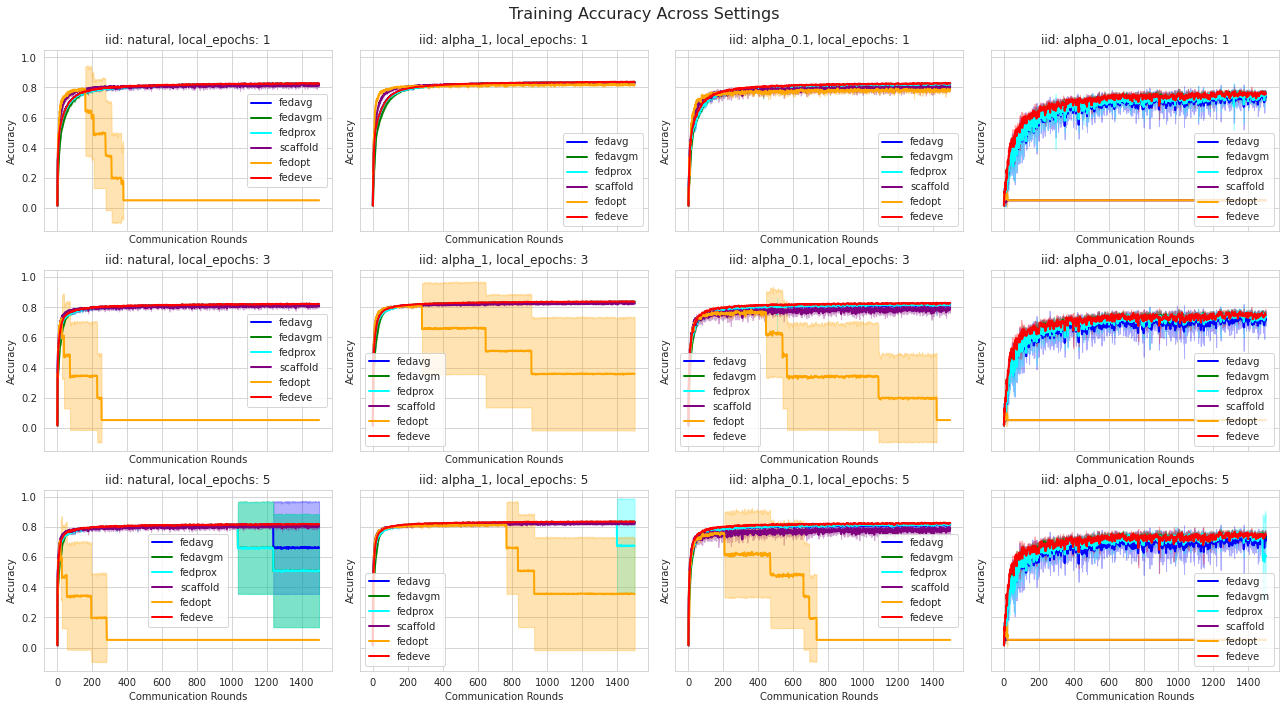

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original data
df = pd.read_csv('nips_2023_rebuttal_different_local_epochs_femnist.csv')
df['recorder'] = df['recorder'].str.replace('nan', 'np.nan')
df['recorder'] = df['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df['acc_list'] = df['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_relevant = df[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

# Load the fedeve data and combine it with the original data
df_fedeve = pd.read_csv('nips_2023_rebuttal_fedeve_femnist.csv')
df_fedeve['recorder'] = df_fedeve['recorder'].str.replace('nan', 'np.nan')
df_fedeve = df_fedeve[df_fedeve['recorder'].apply(lambda x: 'loss' in eval(x) and not any(pd.isna(eval(x)['loss'])))]
df_fedeve['recorder'] = df_fedeve['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df_fedeve['acc_list'] = df_fedeve['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)

df_fedeve_relevant = df_fedeve[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

df_combined = pd.concat([df_relevant, df_fedeve_relevant])

# Update methods list and color map
methods = ["fedavg", "fedavgm", "fedprox", "scaffold", "fedopt", "fedeve"]
color_map = {
    'fedavg': 'blue',
    'fedavgm': 'green',
    'fedprox': 'cyan',
    'scaffold': 'purple',
    'fedopt': 'orange',
    'fedeve': 'red'
}

# Plotting settings
iid_settings = ["natural", "alpha_1", "alpha_0.1", "alpha_0.01"]
local_epochs_settings = [1, 3, 5]
sns.set_style("whitegrid")
sns.set_palette("deep")

# Plot the data again
fig, axes = plt.subplots(len(local_epochs_settings), len(iid_settings), figsize=(18, 10), sharex=True, sharey=True)
for j, iid_setting in enumerate(iid_settings):
    for i, local_epoch in enumerate(local_epochs_settings):
        ax = axes[i, j]
        for method in methods:
            subset = df_combined[(df_combined['iid'] == iid_setting) & 
                                 (df_combined['local_epochs'] == local_epoch) & 
                                 (df_combined['method'] == method)]
            if not subset.empty:
                acc_values = list(subset['acc_list'])
                mean_acc = np.mean(acc_values, axis=0)
                std_acc = np.std(acc_values, axis=0)
                epochs = range(len(mean_acc))
                ax.plot(epochs, mean_acc, label=method, color=color_map[method], linewidth=2)
                ax.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)
        ax.set_title(f"iid: {iid_setting}, local_epochs: {local_epoch}")
        ax.set_xlabel("Communication Rounds", fontsize=10)
        ax.set_ylabel("Accuracy", fontsize=10)
        ax.legend(frameon=True)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Training Accuracy Across Settings", fontsize=16)
plt.show()
fig.savefig('training_accuracy_across_settings_with_fedeve.pdf', bbox_inches='tight')



/tmp/ipykernel_20786/86401029.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


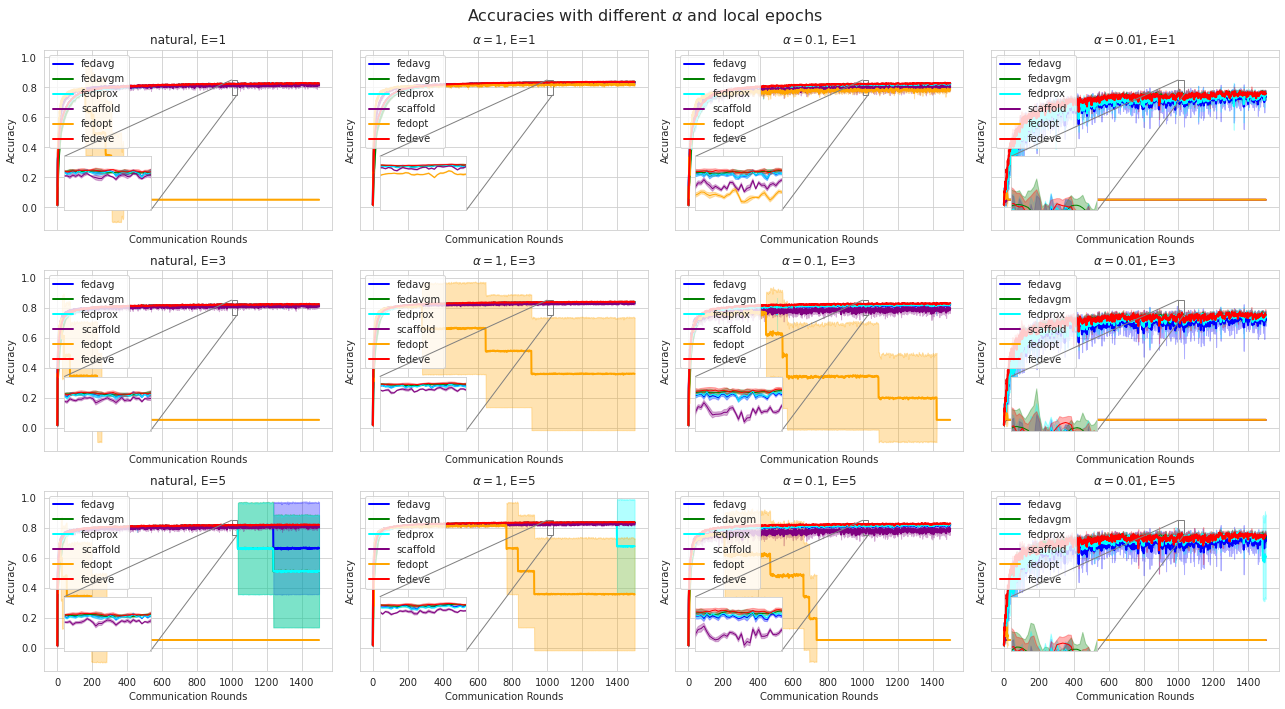

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Load the original data
df = pd.read_csv('nips_2023_rebuttal_different_local_epochs_femnist.csv')
df['recorder'] = df['recorder'].str.replace('nan', 'np.nan')
df['recorder'] = df['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df['acc_list'] = df['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_relevant = df[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

# Load the fedeve data
df_fedeve = pd.read_csv('nips_2023_rebuttal_fedeve_femnist.csv')
df_fedeve['recorder'] = df_fedeve['recorder'].str.replace('nan', 'np.nan')
df_fedeve = df_fedeve[df_fedeve['recorder'].apply(lambda x: 'loss' in eval(x) and not any(pd.isna(eval(x)['loss'])))]
df_fedeve['recorder'] = df_fedeve['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df_fedeve['acc_list'] = df_fedeve['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_fedeve_relevant = df_fedeve[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

# Combine the data
df_combined = pd.concat([df_relevant, df_fedeve_relevant])

# Redefining necessary settings
alpha={'natural':r"natural",'alpha_1':r"$\alpha=1$",'alpha_0.1':r"$\alpha=0.1$",'alpha_0.01':r"$\alpha=0.01$"}

# Define methods and color map
methods = ["fedavg", "fedavgm", "fedprox", "scaffold", "fedopt", "fedeve"]
color_map = {
    'fedavg': 'blue',
    'fedavgm': 'green',
    'fedprox': 'cyan',
    'scaffold': 'purple',
    'fedopt': 'orange',
    'fedeve': 'red'
}

# Plotting settings
iid_settings = ["natural", "alpha_1", "alpha_0.1", "alpha_0.01"]
local_epochs_settings = [1, 3, 5]
sns.set_style("whitegrid")
sns.set_palette("deep")

# Plot the data with correctly zoomed-in area again
fig, axes = plt.subplots(len(local_epochs_settings), len(iid_settings), figsize=(18, 10), sharex=True, sharey=True)

for j, iid_setting in enumerate(iid_settings):
    for i, local_epoch in enumerate(local_epochs_settings):
        ax = axes[i, j]
        
        max_acc = 0  # variable to store maximum accuracy across all methods for current subplot
        min_acc = 1  # variable to store minimum accuracy across all methods for current subplot
        
        for method in methods:
            subset = df_combined[(df_combined['iid'] == iid_setting) & 
                                 (df_combined['local_epochs'] == local_epoch) & 
                                 (df_combined['method'] == method)]
            if not subset.empty:
                acc_values = list(subset['acc_list'])
                mean_acc = np.mean(acc_values, axis=0)
                max_acc = max(max_acc, max(mean_acc))
                min_acc = min(min_acc, min(mean_acc))
                std_acc = np.std(acc_values, axis=0)
                epochs = range(len(mean_acc))
                ax.plot(epochs, mean_acc, label=method, color=color_map[method], linewidth=2)
                ax.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)
        
        # Set up the zoom effect for each subplot
        axins = inset_axes(ax, width="30%", height="30%", loc="lower left", borderpad=2)
        
        for method in methods:
            subset = df_combined[(df_combined['iid'] == iid_setting) & 
                                 (df_combined['local_epochs'] == local_epoch) & 
                                 (df_combined['method'] == method)]
            if not subset.empty:
                acc_values = list(subset['acc_list'])
                mean_acc = np.mean(acc_values, axis=0)
                epochs = range(len(mean_acc))
                axins.plot(epochs, mean_acc, label=method, color=color_map[method], linewidth=1)
                axins.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)
        
        # Define the zoom-in area focusing on the top accuracies
        x1, x2, y1, y2 = 1000, 1030, min_acc, max_acc  # specify the limits for zoom
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        
        # Remove the ticks in the zoom-in area
        axins.set_xticks([])
        axins.set_yticks([])
        
        # Draw the connection lines between the original plot and the zoom-in area
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)
        
        ax.set_title(alpha[iid_setting]+ r", E={}".format(local_epoch))
        ax.set_xlabel("Communication Rounds", fontsize=10)
        ax.set_ylabel("Accuracy", fontsize=10)
        ax.legend(frameon=True, loc="upper left")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(r"Accuracies with different $\alpha$ and local epochs", fontsize=16)
plt.show()
fig.savefig('training_accuracy_across_settings_with_correct_zoom_and_fedeve.pdf', bbox_inches='tight')


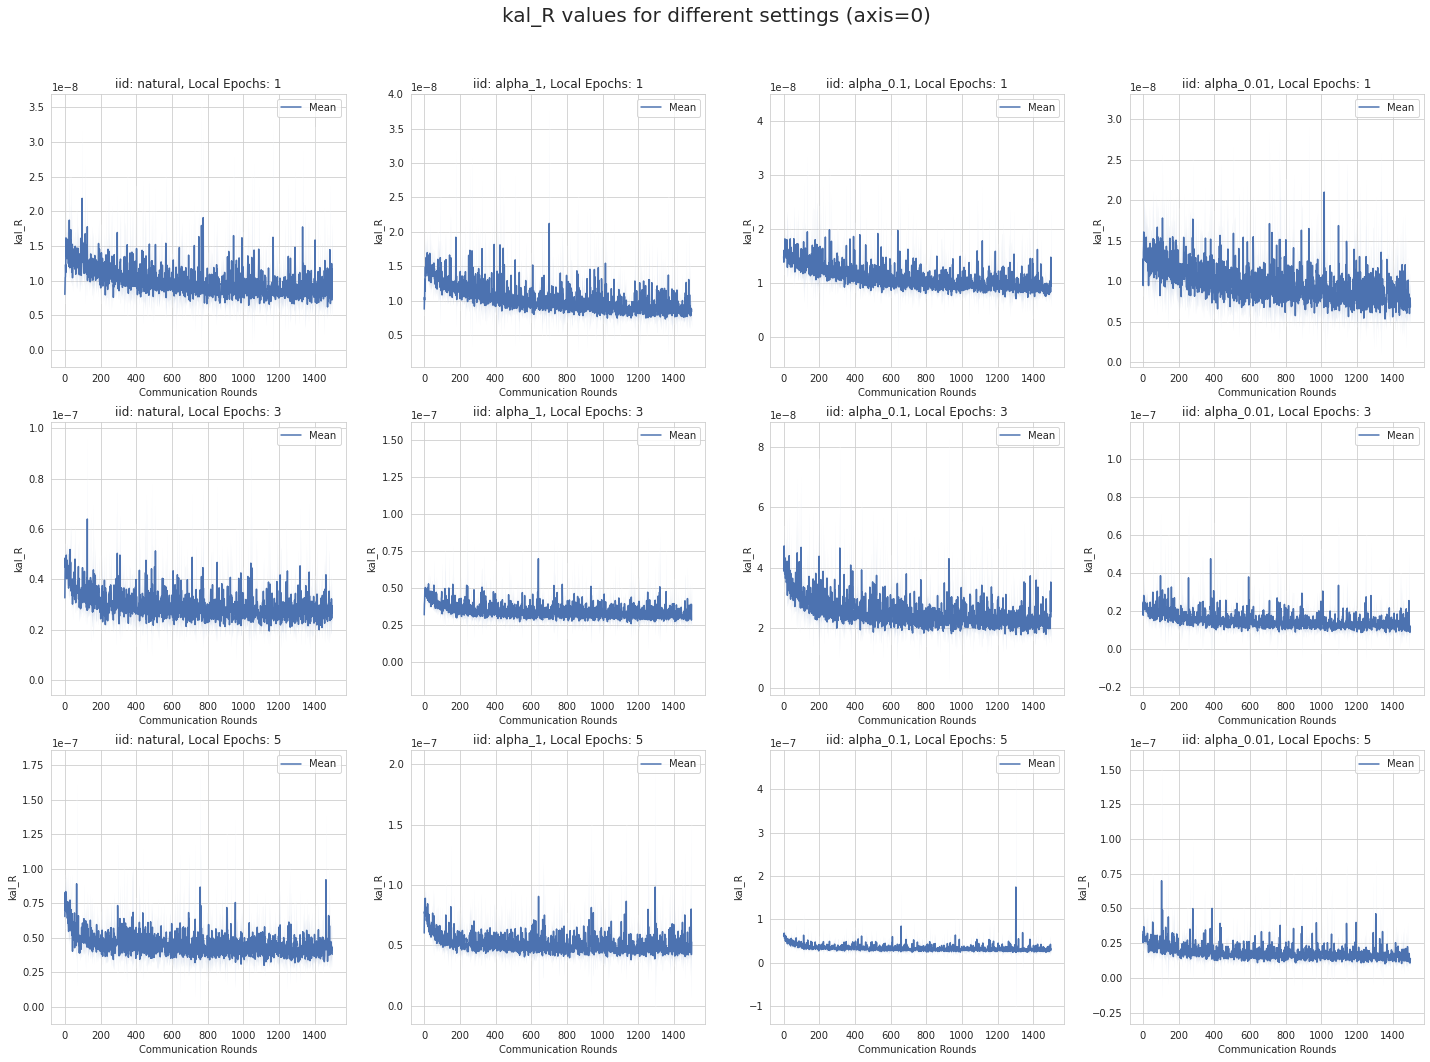

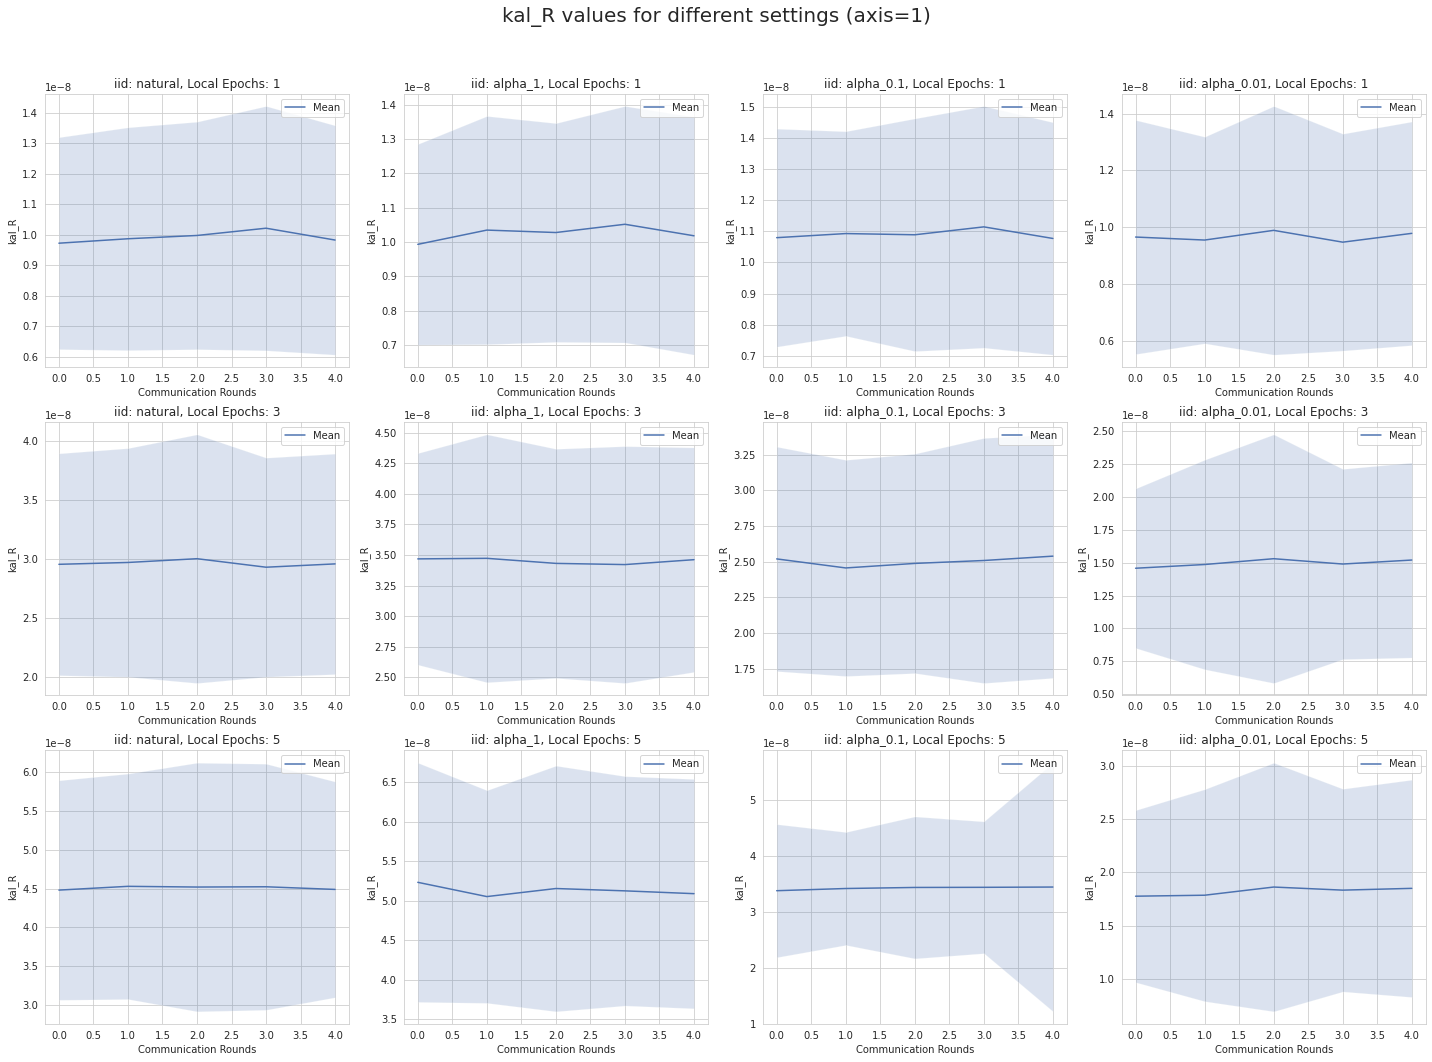

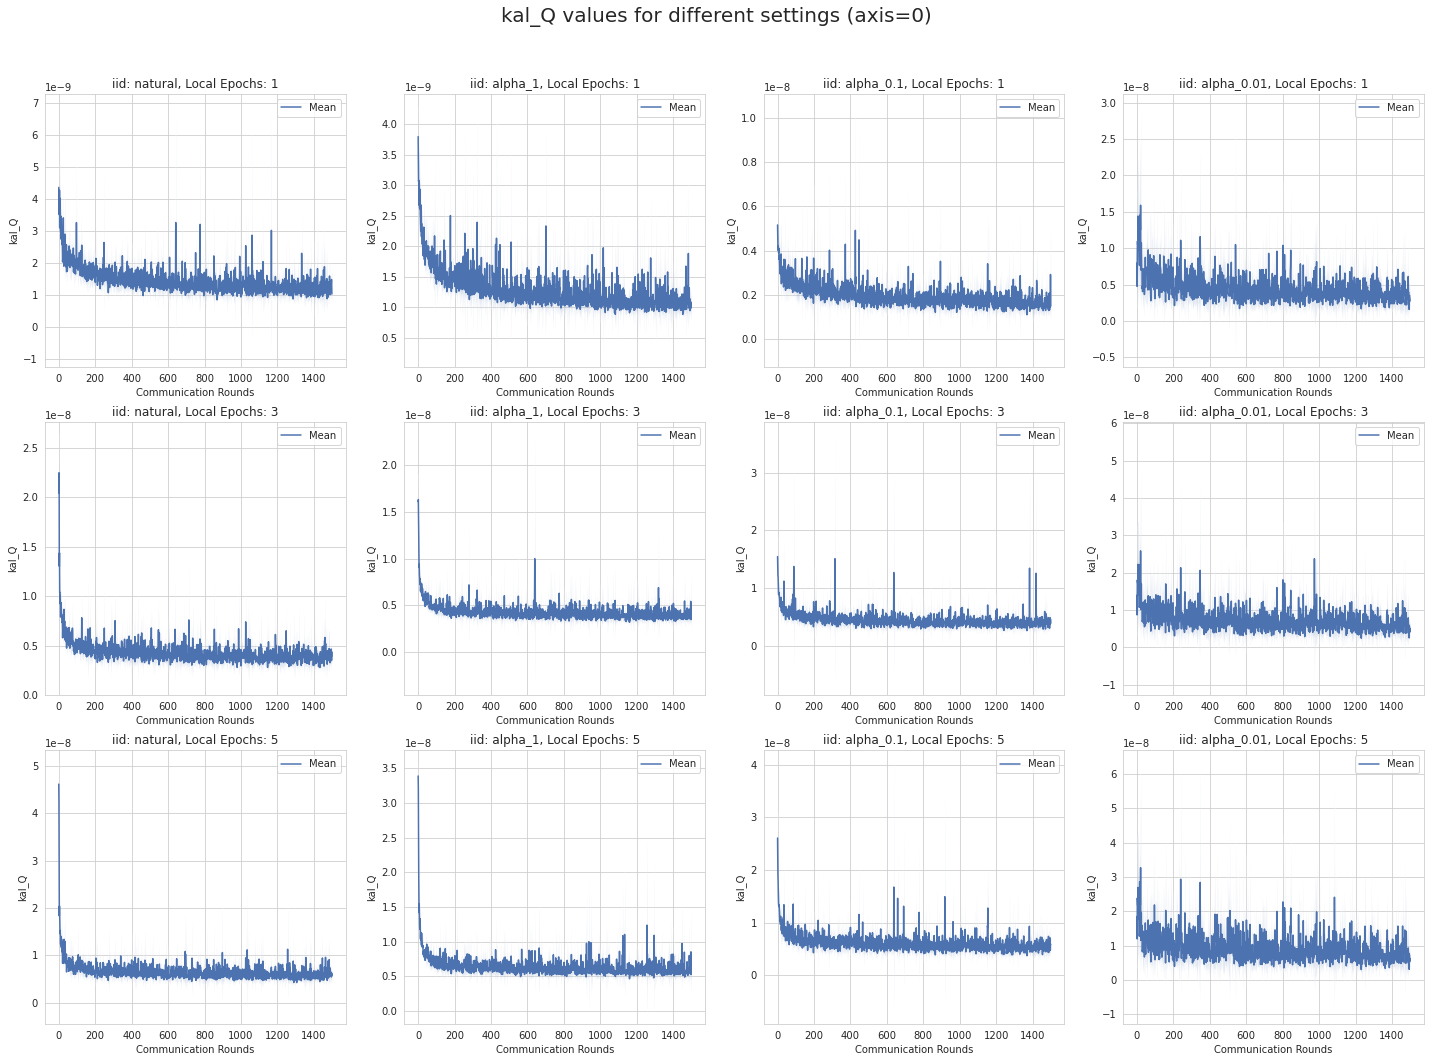

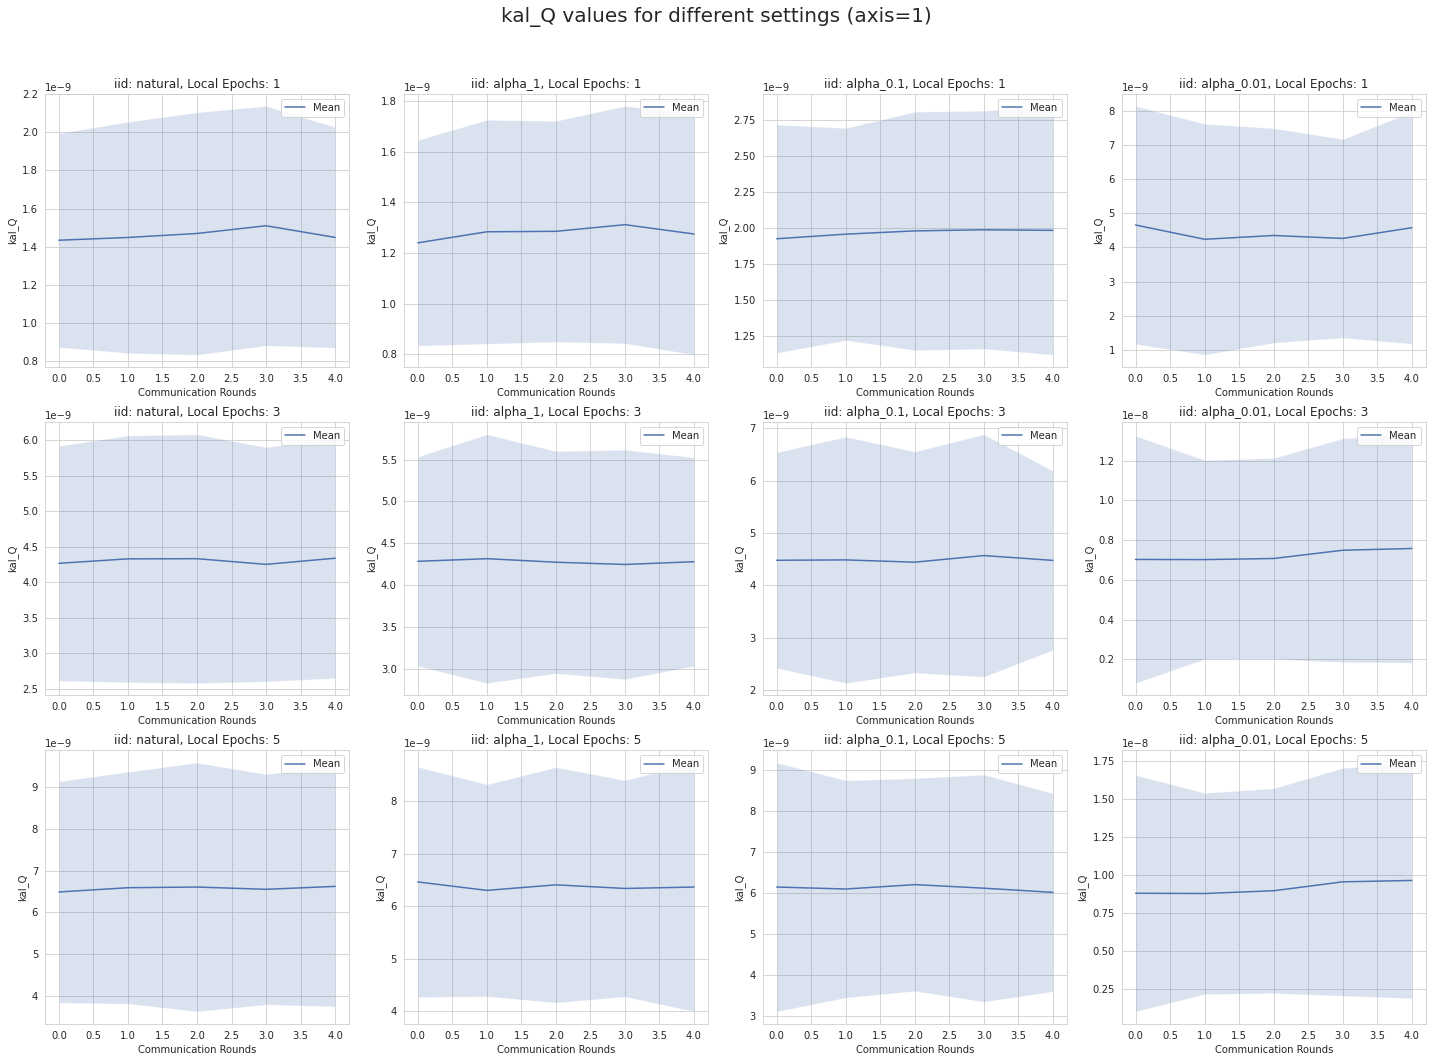

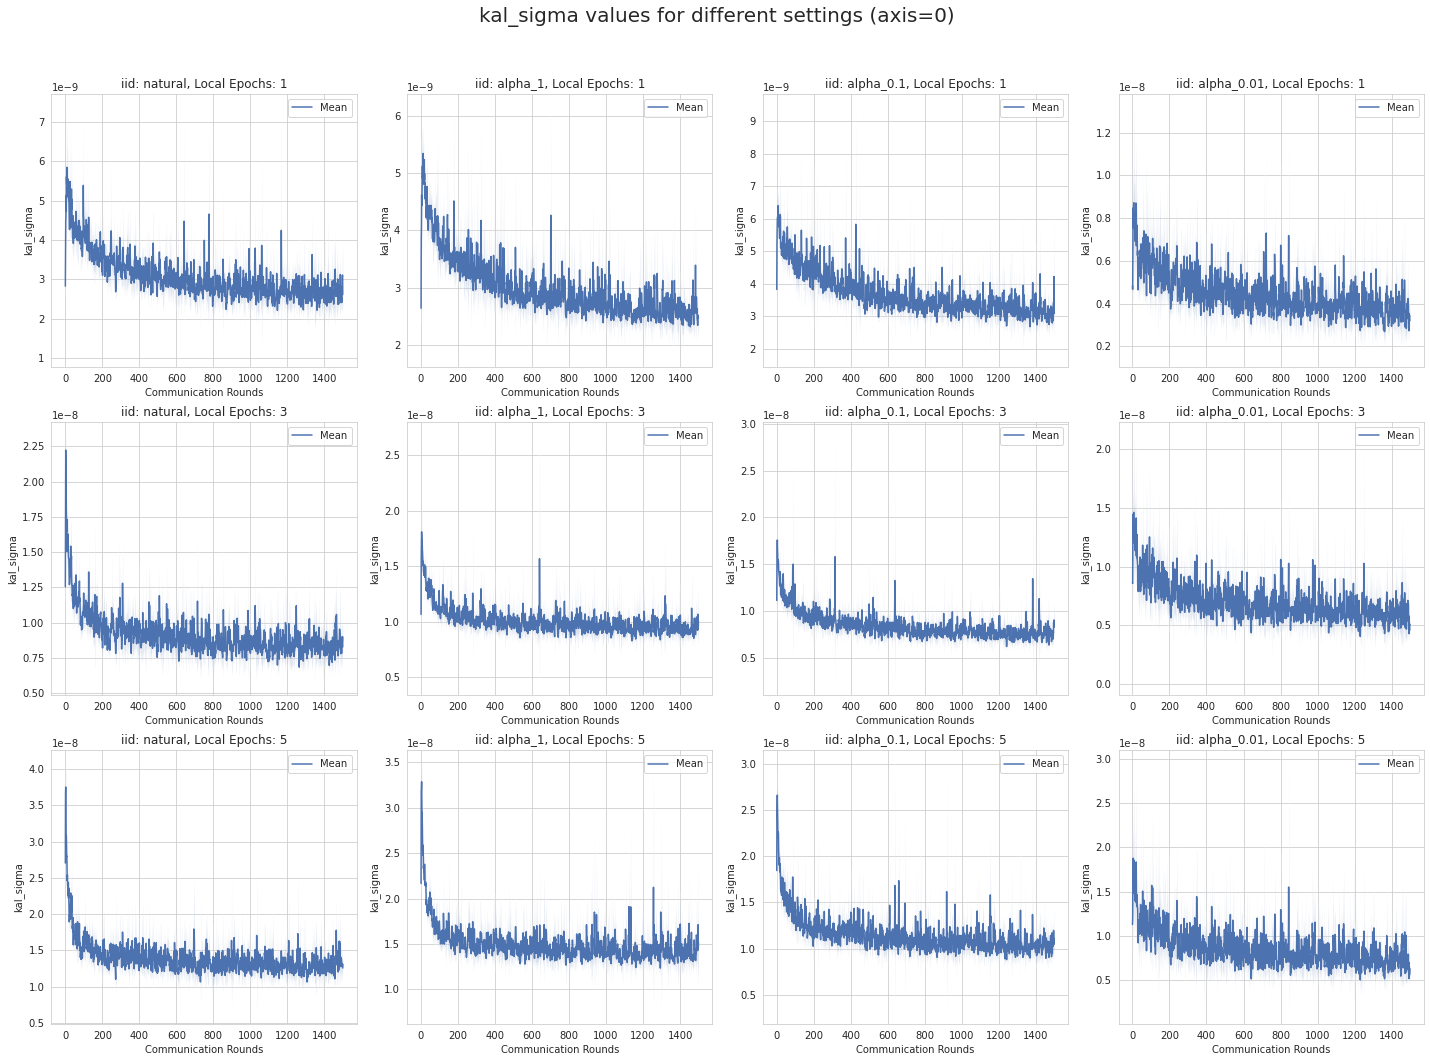

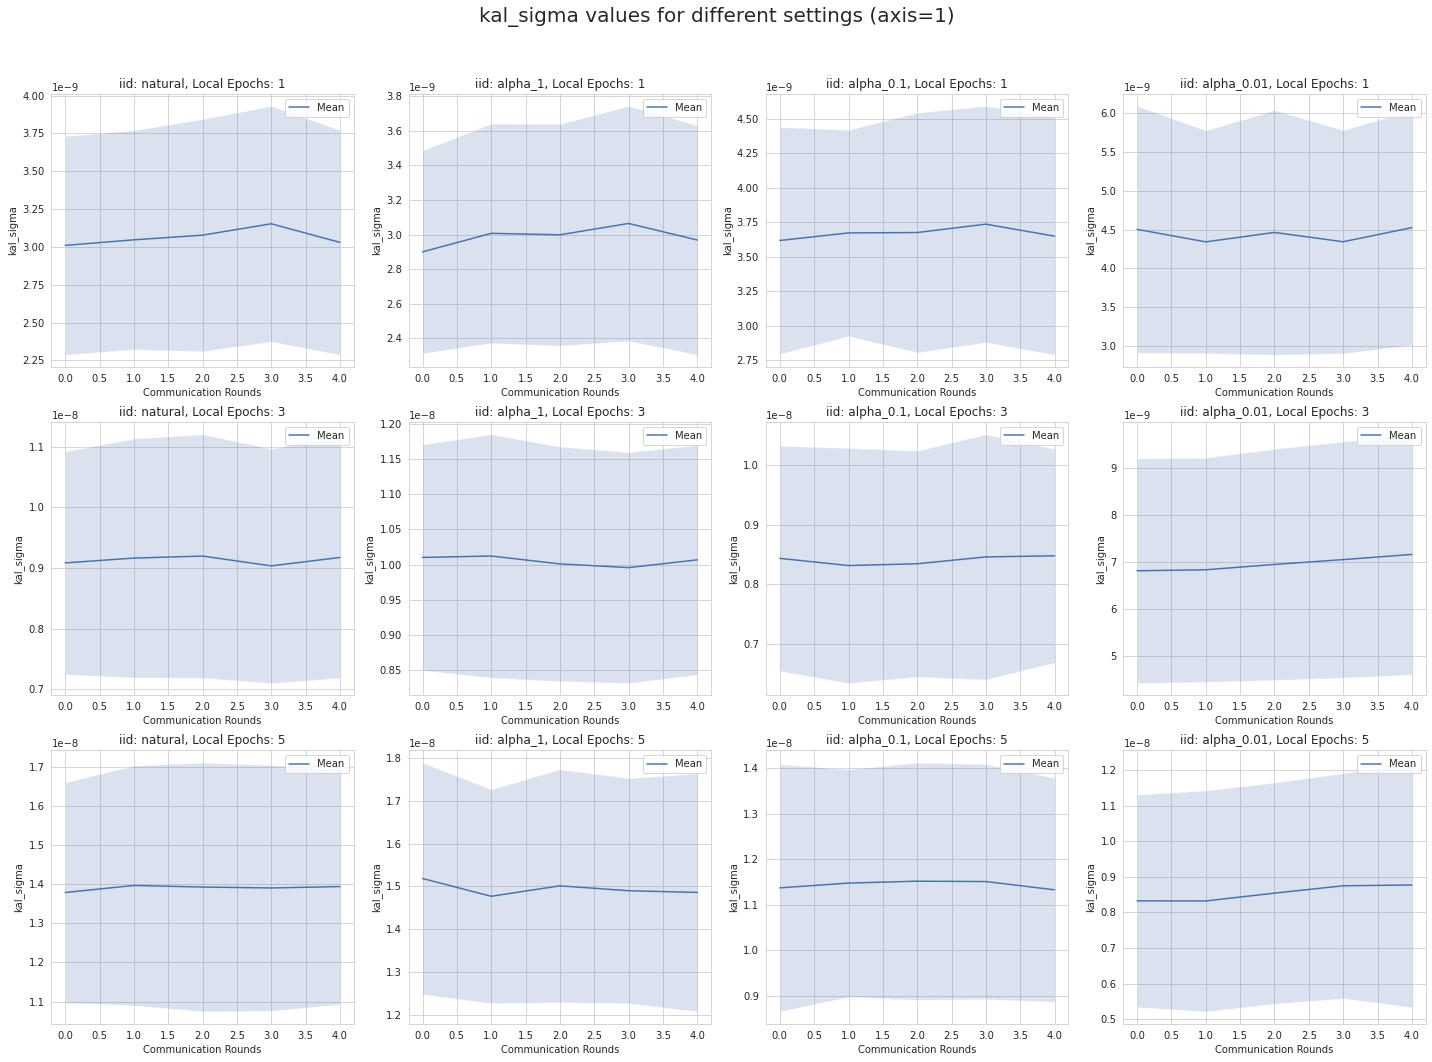

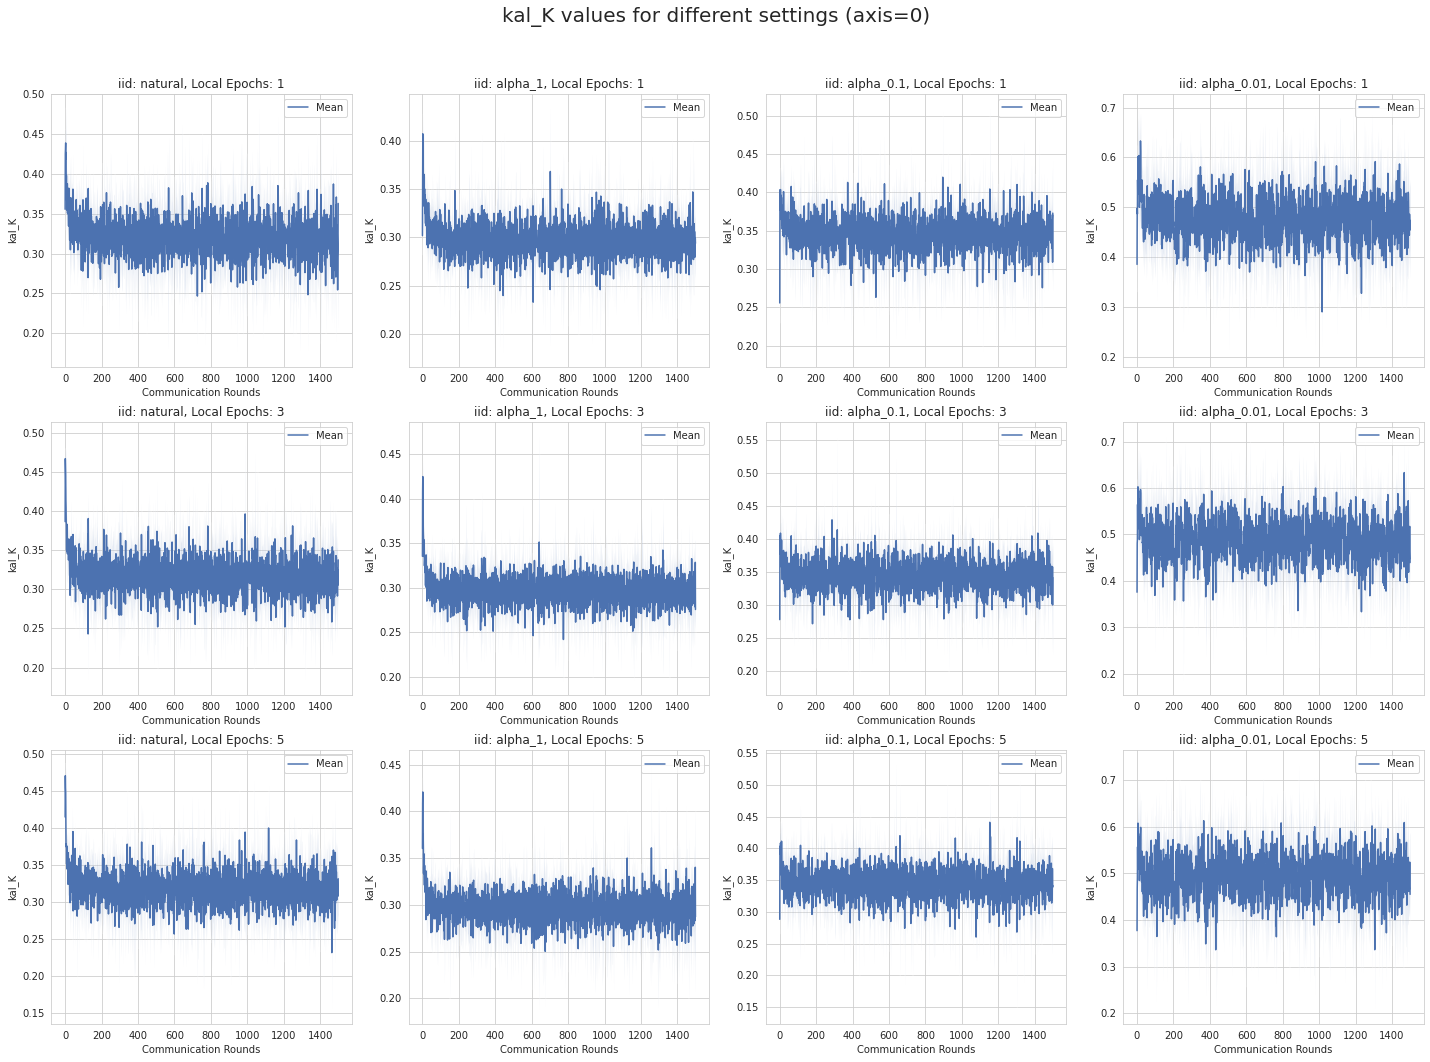

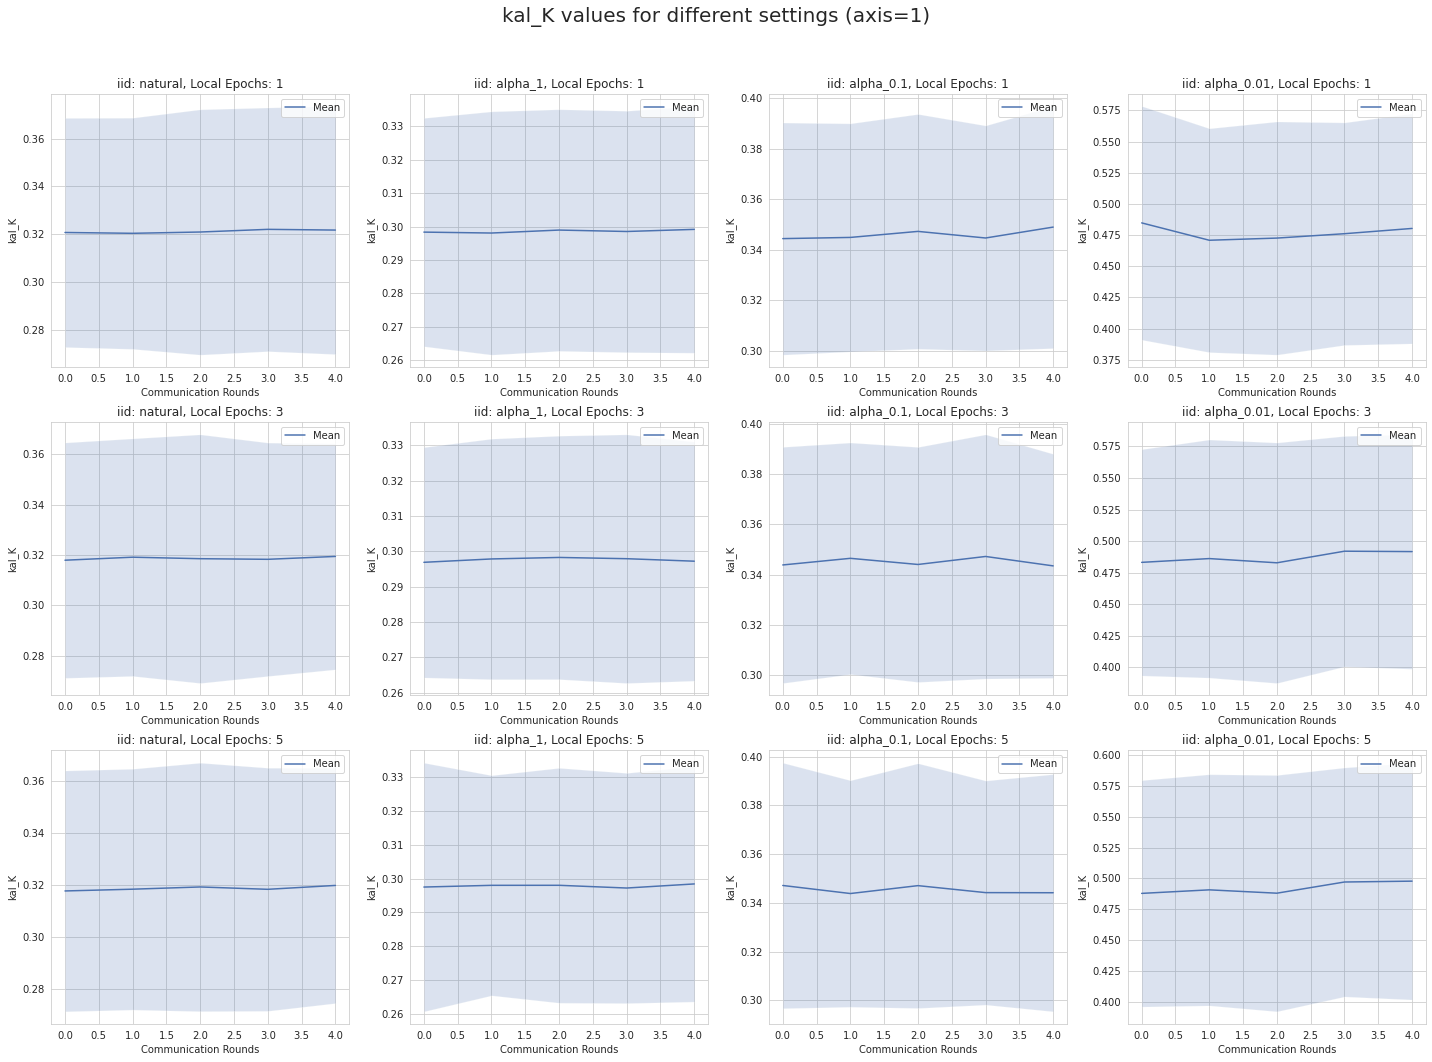

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('nips_2023_rebuttal_fedeve_femnist.csv')

# Define settings and columns of interest
iid_settings_updated = ['natural', 'alpha_1', 'alpha_0.1', 'alpha_0.01']
local_epochs_settings = [1, 3, 5]
columns = ['kal_R', 'kal_Q', 'kal_sigma', 'kal_K']

# Function to extract Kalman parameters
def extract_kalman_from_recorder(param, data_frame):
    all_values = []
    for entry in data_frame['recorder']:
        try:
            parsed_entry = eval(entry)
            all_values.append(parsed_entry[param])
        except:
            all_values.append([])
    return all_values

# Function to compute mean and std
def compute_mean_std(all_values, axis):
    max_length = max(map(len, all_values))
    padded_values = [values + [np.nan] * (max_length - len(values)) for values in all_values]
    array_values = np.array(padded_values)
    mean_values = np.nanmean(array_values, axis=axis)
    std_values = np.nanstd(array_values, axis=axis)
    return mean_values, std_values

# Function to generate stats data
def generate_stats_data(axis):
    stats_data = {}
    for iid in iid_settings_updated:
        for epochs in local_epochs_settings:
            key = f"{iid}_epochs{epochs}"
            stats_data[key] = {}
            filtered_data = df[(df['iid'] == iid) & (df['local_epochs'] == epochs)]
            for col in columns:
                all_values = extract_kalman_from_recorder(col, filtered_data)
                mean_values, std_values = compute_mean_std(all_values, axis)
                stats_data[key][col] = {
                    'mean_values': mean_values,
                    'std_values': std_values,
                    'overall_mean': np.mean(mean_values),
                    'overall_std': np.mean(std_values),
                }
    return stats_data

# Function to plot the stats data
def plot_kalman_parameter_for_axis(parameter, stats_data, title_suffix):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    fig.suptitle(f"{parameter} values for different settings {title_suffix}", fontsize=20)
    for idx, iid in enumerate(iid_settings_updated):
        for jdx, epochs in enumerate(local_epochs_settings):
            ax = axes[jdx, idx]
            key = f"{iid}_epochs{epochs}"
            mean_values = stats_data[key][parameter]['mean_values']
            std_values = stats_data[key][parameter]['std_values']
            rounds = list(range(len(mean_values)))
            ax.plot(rounds, mean_values, label='Mean')
            ax.fill_between(rounds, mean_values - std_values, mean_values + std_values, alpha=0.2)
            ax.set_title(f"iid: {iid}, Local Epochs: {epochs}")
            ax.set_xlabel("Communication Rounds")
            ax.set_ylabel(parameter)
            ax.legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Generate stats data and plot for both axis=0 and axis=1
stats_data_axis0 = generate_stats_data(0)
stats_data_axis1 = generate_stats_data(1)
for param in columns:
    plot_kalman_parameter_for_axis(param, stats_data_axis0, title_suffix="(axis=0)")
    plot_kalman_parameter_for_axis(param, stats_data_axis1, title_suffix="(axis=1)")


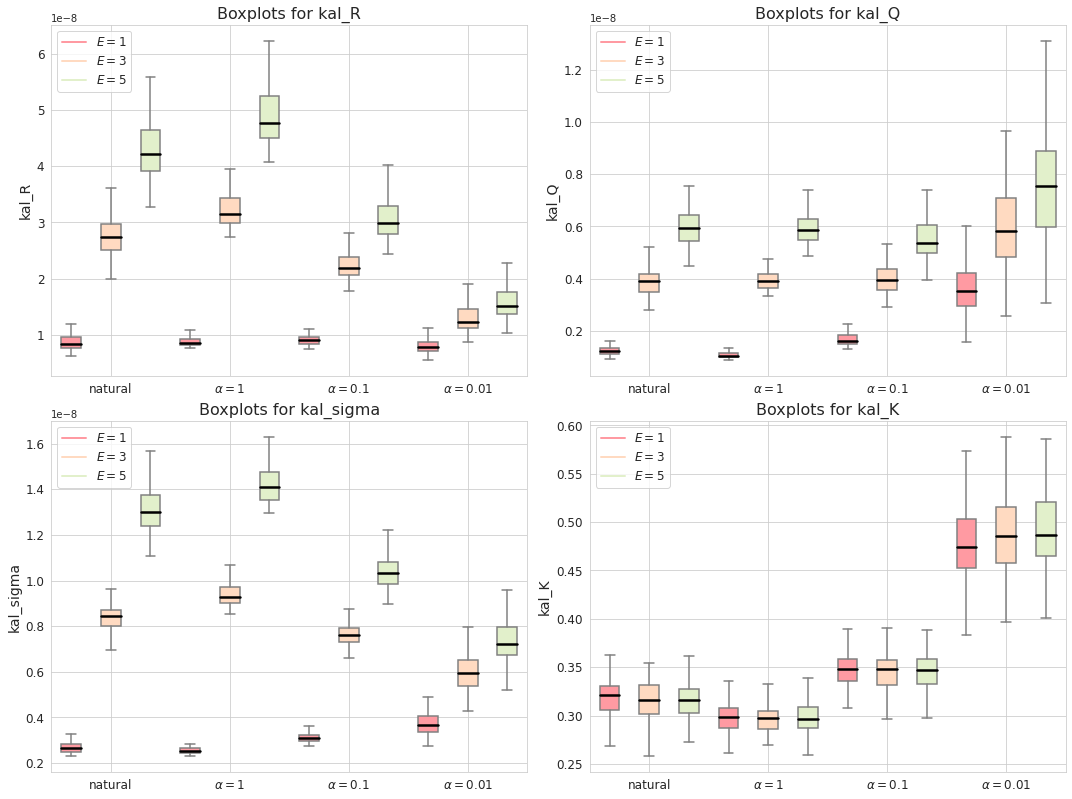

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('nips_2023_rebuttal_fedeve_femnist.csv')

# Define settings and columns of interest
iid_settings_updated = ['natural', 'alpha_1', 'alpha_0.1', 'alpha_0.01']
local_epochs_settings = [1, 3, 5]
columns = ['kal_R', 'kal_Q', 'kal_sigma', 'kal_K']

# Function to extract Kalman parameters
def extract_kalman_from_recorder(param, data_frame):
    all_values = []
    for entry in data_frame['recorder']:
        try:
            parsed_entry = eval(entry)
            all_values.append(parsed_entry[param])
        except:
            all_values.append([])
    return all_values

# Function to compute mean and std
def compute_mean_std(all_values, axis):
    max_length = max(map(len, all_values))
    padded_values = [values + [np.nan] * (max_length - len(values)) for values in all_values]
    array_values = np.array(padded_values)
    mean_values = np.nanmean(array_values, axis=axis)
    std_values = np.nanstd(array_values, axis=axis)
    return mean_values, std_values

# Function to generate stats data
def generate_stats_data(axis):
    stats_data = {}
    for iid in iid_settings_updated:
        for epochs in local_epochs_settings:
            key = f"{iid}_epochs{epochs}"
            stats_data[key] = {}
            filtered_data = df[(df['iid'] == iid) & (df['local_epochs'] == epochs)]
            for col in columns:
                all_values = extract_kalman_from_recorder(col, filtered_data)
                mean_values, std_values = compute_mean_std(all_values, axis)
                stats_data[key][col] = {
                    'mean_values': mean_values,
                    'std_values': std_values,
                    'overall_mean': np.mean(mean_values),
                    'overall_std': np.mean(std_values),
                }
    return stats_data

# Function to plot the stats data
def plot_kalman_parameter_for_axis(parameter, stats_data, title_suffix):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    fig.suptitle(f"{parameter} values for different settings {title_suffix}", fontsize=20)
    for idx, iid in enumerate(iid_settings_updated):
        for jdx, epochs in enumerate(local_epochs_settings):
            ax = axes[jdx, idx]
            key = f"{iid}_epochs{epochs}"
            mean_values = stats_data[key][parameter]['mean_values']
            std_values = stats_data[key][parameter]['std_values']
            rounds = list(range(len(mean_values)))
            ax.plot(rounds, mean_values, label='Mean')
            ax.fill_between(rounds, mean_values - std_values, mean_values + std_values, alpha=0.2)
            ax.set_title(f"iid: {iid}, Local Epochs: {epochs}")
            ax.set_xlabel("Communication Rounds")
            ax.set_ylabel(parameter)
            ax.legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Generate stats data and plot for both axis=0 and axis=1
stats_data_axis0 = generate_stats_data(0)
stats_data_axis1 = generate_stats_data(1)



improved_epoch_colors = {
    1: '#FF9AA2',
    3: '#FFDAC1',
    5: '#E2F0CB'
}
iid_settings_updated = ['natural', 'alpha_1', 'alpha_0.1', 'alpha_0.01']
alpha={'natural':r"natural",'alpha_1':r"$\alpha=1$",'alpha_0.1':r"$\alpha=0.1$",'alpha_0.01':r"$\alpha=0.01$"}
xlabels=[r"natural",r"$\alpha=1$",r"$\alpha=0.1$",r"$\alpha=0.01$"]
kalman_params=['kal_R', 'kal_Q', 'kal_sigma', 'kal_K']
def plot_enhanced_boxplots(stats_data, last_n=100):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    boxprops = dict(linewidth=1.5, color='gray')
    medianprops = dict(linewidth=2.5, color='black')
    whiskerprops = dict(linewidth=1.5, color='gray')
    capprops = dict(linewidth=1.5, color='gray')
    
    for ax, param in zip(axes.ravel(), kalman_params):
        all_data = []
        for iid in iid_settings_updated:
            for epochs in local_epochs_settings:
                setting_data = stats_data[f"{iid}_epochs{epochs}"][param]['mean_values'][-last_n:]
                all_data.append(setting_data)
        box_positions = range(1, len(iid_settings_updated) * len(local_epochs_settings) + 1)
        bp = ax.boxplot(all_data, positions=box_positions, patch_artist=True, showfliers=False, 
                        boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
        for patch, (_, epochs) in zip(bp['boxes'], [(iid, epochs) for iid in iid_settings_updated for epochs in local_epochs_settings]):
            patch.set_facecolor(improved_epoch_colors[epochs])
        ax.set_xticks([np.mean(group) for group in np.array_split(box_positions, len(iid_settings_updated))])
        ax.set_xticklabels(xlabels)
        ax.set_title(f"Boxplots for {param}", fontsize=16)
        ax.set_ylabel(param, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        custom_lines = [plt.Line2D([0], [0], color=improved_epoch_colors[epoch], lw=2) for epoch in local_epochs_settings]
        ax.legend(custom_lines, [r"$E={}$".format(epoch) for epoch in local_epochs_settings], loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    fig.savefig('fedeve_kallman.pdf', bbox_inches='tight')


plot_enhanced_boxplots(stats_data_axis0)


In [45]:
import pandas as pd
import numpy as np

# Load the original data
df = pd.read_csv('nips_2023_rebuttal_different_local_epochs_femnist.csv')
df['recorder'] = df['recorder'].str.replace('nan', 'np.nan')
df['recorder'] = df['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df['acc_list'] = df['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_relevant = df[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

# Load the fedeve data
df_fedeve = pd.read_csv('nips_2023_rebuttal_fedeve_femnist.csv')
df_fedeve['recorder'] = df_fedeve['recorder'].str.replace('nan', 'np.nan')
df_fedeve = df_fedeve[df_fedeve['recorder'].apply(lambda x: 'loss' in eval(x) and not any(pd.isna(eval(x)['loss'])))]
df_fedeve['recorder'] = df_fedeve['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df_fedeve['acc_list'] = df_fedeve['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_fedeve_relevant = df_fedeve[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

# Combine the data
df_combined = pd.concat([df_relevant, df_fedeve_relevant])

# Define variables
methods = ['fedavg', 'fedavgm', 'fedprox', 'scaffold', 'fedopt', 'fedeve']
settings = ['natural', 'alpha_1', 'alpha_0.1', 'alpha_0.01']
local_epochs_list = [1, 3, 5]
n = 10

# Compute mean and standard deviation for each cell
means = np.zeros((len(methods), len(settings), len(local_epochs_list)))
stds = np.zeros((len(methods), len(settings), len(local_epochs_list)))

for i, method in enumerate(methods):
    for j, iid in enumerate(settings):
        for k, local_epochs in enumerate(local_epochs_list):
            subset = df_combined[(df_combined['method'] == method) & 
                                 (df_combined['iid'] == iid) & 
                                 (df_combined['local_epochs'] == local_epochs)]
            
            accs = [sum(acc[-n:]) / n for acc in subset['acc_list']]
            
            means[i, j, k] = np.mean(accs)
            stds[i, j, k] = np.std(accs)

# Generate table
table_rows = []
for i, method in enumerate(methods):
    row = [f"\\{method}"]
    for j, iid in enumerate(settings):
        for k, local_epochs in enumerate(local_epochs_list):
            if np.isclose(means[i, j, k], np.max(means[:, j, k])):
                row.append(f"\\textbf{{{means[i, j, k]*100:.2f} $\\pm$ {stds[i, j, k]*100:.2f}}}")
            else:
                row.append(f"{means[i, j, k]*100:.2f} $\\pm$ {stds[i, j, k]*100:.2f}")
    table_rows.append(row)

# Combine table elements
table_headers = ["Method"]
for iid in settings:
    if "alpha" in iid:
        formatted_iid = iid.replace("alpha_", "$\\alpha=") + "$"
    else:
        formatted_iid = iid
    table_headers.append(f"\\multicolumn{{3}}{{c}}{{{formatted_iid}}}")

header_row_1 = " & ".join(table_headers)
header_row_2 = "& " + " & ".join([" & ".join([str(le) for le in local_epochs_list]) for _ in settings])

tex = (
    "\\begin{table}[]\n"
    "\\centering\n"
    "\\caption{Results for femnist}\n"
    "\\label{tab:femnist}\n"
    "\\resizebox{1\\linewidth}{!}{"
    f"\\begin{{tabular}}{{l{'c'*len(settings)*len(local_epochs_list)}}}\n"
    "\\toprule\n"
    f"{header_row_1} \\\\\n"
    f"{header_row_2} \\\\\n"
    "\\midrule\n"
    + "\n".join([" & ".join(row) + " \\\\" for row in table_rows])
    + "\n\\bottomrule\n"
    "\\end{tabular}"
    "}\n"
    "\\end{table}"
)

# Print table
print(tex)


\begin{table}[]
\centering
\caption{Results for femnist}
\label{tab:femnist}
\resizebox{1\linewidth}{!}{\begin{tabular}{lcccccccccccc}
\toprule
Method & \multicolumn{3}{c}{natural} & \multicolumn{3}{c}{$\alpha=1$} & \multicolumn{3}{c}{$\alpha=0.1$} & \multicolumn{3}{c}{$\alpha=0.01$} \\
& 1 & 3 & 5 & 1 & 3 & 5 & 1 & 3 & 5 & 1 & 3 & 5 \\
\midrule
\fedavg & 82.46 $\pm$ 0.18 & 81.95 $\pm$ 0.26 & 66.38 $\pm$ 30.63 & 83.64 $\pm$ 0.11 & 83.57 $\pm$ 0.12 & 83.38 $\pm$ 0.09 & 82.12 $\pm$ 0.23 & 81.91 $\pm$ 0.23 & 81.70 $\pm$ 0.26 & 74.51 $\pm$ 1.36 & 73.43 $\pm$ 1.73 & 72.67 $\pm$ 1.39 \\
\fedavgm & 82.55 $\pm$ 0.43 & 81.99 $\pm$ 0.42 & 50.97 $\pm$ 37.43 & 83.67 $\pm$ 0.10 & 83.79 $\pm$ 0.11 & 83.65 $\pm$ 0.08 & 82.36 $\pm$ 0.49 & 82.23 $\pm$ 0.26 & 82.16 $\pm$ 0.34 & 75.18 $\pm$ 2.34 & 74.20 $\pm$ 2.81 & 73.79 $\pm$ 3.13 \\
\fedprox & 82.43 $\pm$ 0.17 & 81.90 $\pm$ 0.27 & 51.07 $\pm$ 37.51 & 83.62 $\pm$ 0.11 & 83.52 $\pm$ 0.14 & 67.65 $\pm$ 31.26 & 82.17 $\pm$ 0.27 & 82.12 $\pm$ 0.19 & 81.94 

In [46]:
import numpy as np

# ... [其他代码与上述相同]

# Local epoch values
local_epochs_list = [1, 3, 5]

# Generate header rows
header_row_1 = ["\\multirow{2}{*}{Method}"]
for iid in settings:
    if "alpha" in iid:
        formatted_iid = iid.replace("alpha_", "$\\alpha=") + "$"
    else:
        formatted_iid = iid
    header_row_1.append(f"\\multicolumn{{3}}{{c}}{{{formatted_iid}}}")
header_row_1_str = " & ".join(header_row_1)

header_row_2 = []
for _ in settings:
    header_row_2.extend([f"E={le}" for le in local_epochs_list])
header_row_2_str = " & ".join(header_row_2)

cmidrules = " ".join([f"\\cmidrule(lr){{{2+3*i}-{3+3*i}}}" for i in range(len(settings))])

# Generate table rows with data
table_rows = []
for i, method in enumerate(methods):
    row = [f"\\{method[1:-1]}"]
    for j in range(len(settings)):
        for le in local_epochs_list:
            if np.isclose(means[i, j], np.max(means[:, j])):
                row.append(f"\\textbf{{{means[i, j]*100:.4f} $\\pm$ {stds[i, j]*100:.4f}}}")
            else:
                row.append(f"{means[i, j]*100:.4f} $\\pm$ {stds[i, j]*100:.4f}")
    table_rows.append(row)

# Combine table elements
rows_tex = []
for idx, row in enumerate(table_rows):
    row_tex = " & ".join(row)
    if idx % 2 == 0:
        rows_tex.append("\\rowcolor{Gray}")
    rows_tex.append(row_tex)

rows_tex_str = " \\\\\n".join(rows_tex)

tex = (
    "\\begin{table}[]\n"
    "\\centering\n"
    "\\caption{Results for femnist}\n"
    "\\label{tab:femnist}\n"
    "\\resizebox{\\linewidth}{!}{"
    "\\begin{tabular}{l*{12}{c}}\n"
    "\\toprule\n"
    f"{header_row_1_str} \\\\\n"
    f"{cmidrules} \\\\\n"
    f"{header_row_2_str} \\\\\n"
    "\\midrule\n"
    f"{rows_tex_str} \\\\\n"
    "\\bottomrule\n"
    "\\end{tabular}"
    "}\n"
    "\\end{table}"
)

# Print table
print(tex)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

/tmp/ipykernel_29740/2809551682.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


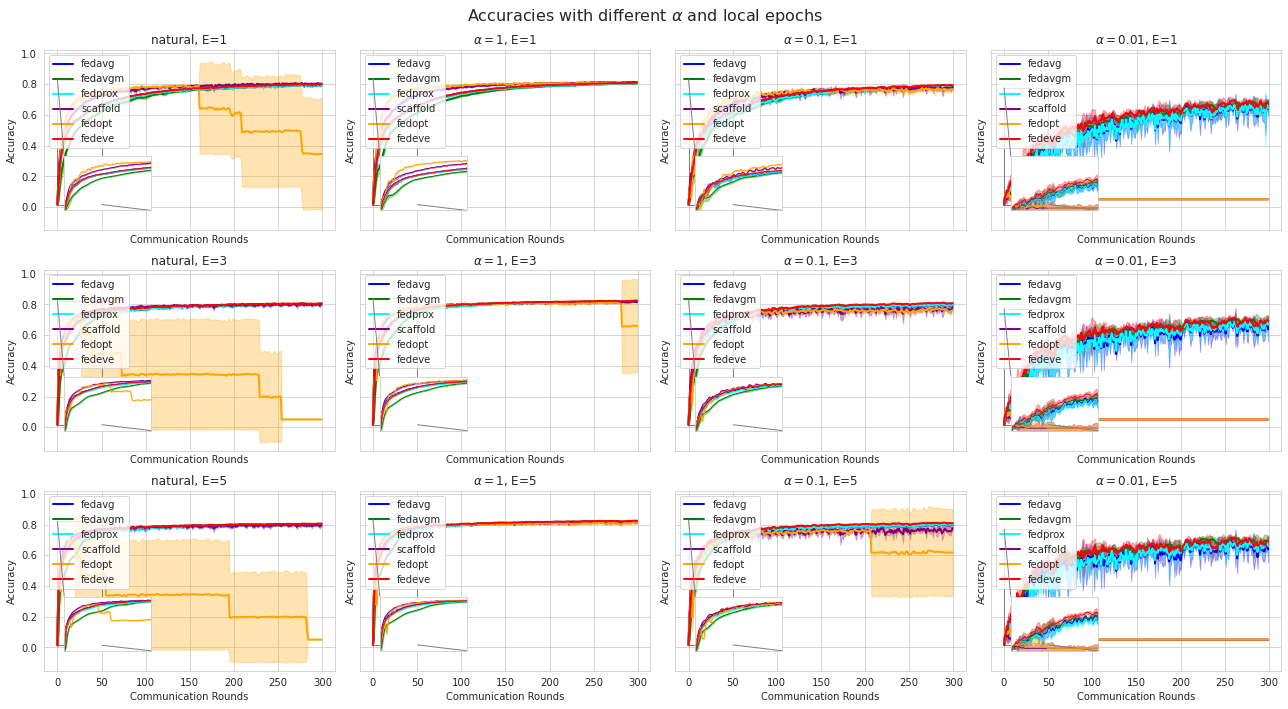

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Load the original data
df = pd.read_csv("nips_2023_rebuttal_different_local_epochs_femnist.csv")
df["recorder"] = df["recorder"].str.replace("nan", "np.nan")
df["recorder"] = df["recorder"].apply(
    lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None
)
df["acc_list"] = df["recorder"].apply(lambda x: x["acc"] if x and "acc" in x else None)
df_relevant = df[["seed", "method", "iid", "local_epochs", "acc_list"]]

# Load the fedeve data
df_fedeve = pd.read_csv("nips_2023_rebuttal_fedeve_femnist.csv")
df_fedeve["recorder"] = df_fedeve["recorder"].str.replace("nan", "np.nan")
df_fedeve = df_fedeve[
    df_fedeve["recorder"].apply(
        lambda x: "loss" in eval(x) and not any(pd.isna(eval(x)["loss"]))
    )
]
df_fedeve["recorder"] = df_fedeve["recorder"].apply(
    lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None
)
df_fedeve["acc_list"] = df_fedeve["recorder"].apply(
    lambda x: x["acc"] if x and "acc" in x else None
)
df_fedeve_relevant = df_fedeve[["seed", "method", "iid", "local_epochs", "acc_list"]]

# Combine the data
df_combined = pd.concat([df_relevant, df_fedeve_relevant])

# Redefining necessary settings
alpha = {
    "natural": r"natural",
    "alpha_1": r"$\alpha=1$",
    "alpha_0.1": r"$\alpha=0.1$",
    "alpha_0.01": r"$\alpha=0.01$",
}

# Define methods and color map
methods = ["fedavg", "fedavgm", "fedprox", "scaffold", "fedopt", "fedeve"]
color_map = {
    "fedavg": "blue",
    "fedavgm": "green",
    "fedprox": "cyan",
    "scaffold": "purple",
    "fedopt": "orange",
    "fedeve": "red",
}

# Plotting settings
iid_settings = ["natural", "alpha_1", "alpha_0.1", "alpha_0.01"]
local_epochs_settings = [1, 3, 5]
sns.set_style("whitegrid")
sns.set_palette("deep")

# Plot the data with correctly zoomed-in area again
fig, axes = plt.subplots(
    len(local_epochs_settings),
    len(iid_settings),
    figsize=(18, 10),
    sharex=True,
    sharey=True,
)
epoch_length=300
for j, iid_setting in enumerate(iid_settings):
    for i, local_epoch in enumerate(local_epochs_settings):
        ax = axes[i, j]

        max_acc = 0  # variable to store maximum accuracy across all methods for current subplot
        min_acc = 1  # variable to store minimum accuracy across all methods for current subplot

        for method in methods:
            subset = df_combined[
                (df_combined["iid"] == iid_setting)
                & (df_combined["local_epochs"] == local_epoch)
                & (df_combined["method"] == method)
            ]
            if not subset.empty:
                acc_values = list(subset["acc_list"])
                mean_acc = np.mean(acc_values, axis=0)
                max_acc = max(max_acc, max(mean_acc))
                min_acc = min(min_acc, min(mean_acc))
                std_acc = np.std(acc_values, axis=0)
                epochs = range(min(300, len(mean_acc)))
                ax.plot(
                    epochs,
                    mean_acc[:epoch_length],
                    label=method,
                    color=color_map[method],
                    linewidth=2,
                )
                ax.fill_between(
                    epochs,
                    mean_acc[:epoch_length] - std_acc[:epoch_length],
                    mean_acc[:epoch_length] + std_acc[:epoch_length],
                    color=color_map[method],
                    alpha=0.3,
                )

        # Set up the zoom effect for each subplot
        axins = inset_axes(ax, width="30%", height="30%", loc="lower left", borderpad=2)

        for method in methods:
            subset = df_combined[
                (df_combined["iid"] == iid_setting)
                & (df_combined["local_epochs"] == local_epoch)
                & (df_combined["method"] == method)
            ]
            if not subset.empty:
                acc_values = list(subset["acc_list"])
                mean_acc = np.mean(acc_values, axis=0)
                epochs = range(min(epoch_length, len(mean_acc)))
                axins.plot(
                    epochs,
                    mean_acc[:epoch_length],
                    label=method,
                    color=color_map[method],
                    linewidth=1,
                )
                axins.fill_between(
                    epochs,
                    mean_acc[:epoch_length] - std_acc[:epoch_length],
                    mean_acc[:epoch_length] + std_acc[:epoch_length],
                    color=color_map[method],
                    alpha=0.3,
                )

        # Define the zoom-in area focusing on the top accuracies
        x1, x2, y1, y2 = 0, 50, min_acc, max_acc  # specify the limits for zoom
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)

        # Remove the ticks in the zoom-in area
        axins.set_xticks([])
        axins.set_yticks([])

        # Draw the connection lines between the original plot and the zoom-in area
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

        ax.set_title(alpha[iid_setting] + r", E={}".format(local_epoch))
        ax.set_xlabel("Communication Rounds", fontsize=10)
        ax.set_ylabel("Accuracy", fontsize=10)
        ax.legend(frameon=True, loc="upper left")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(r"Accuracies with different $\alpha$ and local epochs", fontsize=16)
plt.show()
fig.savefig(
    "training_accuracy_across_settings_with_correct_zoom_and_fedeve_500.pdf",
    bbox_inches="tight",
)

In [ ]:
import pandas as pd
import numpy as np

# 定义你感兴趣的 iid_settings 和 local_epochs_settings
interested_iid_settings = ["alpha_0.01"]  # 举例，你可以根据需要修改
interested_local_epochs_settings = [1]  # 举例，你可以根据需要修改

# 定义方法
methods = ["fedavg", "fedavgm", "fedprox", "scaffold", "fedopt", "fedeve"]

# 加载和准备数据的代码保持不变...

# 从这里开始调整代码，以仅针对特定的 iid 和 local_epochs 设置计算统计数据
results = {}
for method in methods:
    for iid in interested_iid_settings:
        for local_epoch in interested_local_epochs_settings:
            key = (method, iid, local_epoch)
            subset = df_combined[
                (df_combined["method"] == method)
                & (df_combined["iid"] == iid)
                & (df_combined["local_epochs"] == local_epoch)
            ]
            acc_lists = subset["acc_list"].dropna()
            last_100_accs = [acc[-100:] for acc in acc_lists if len(acc) >= 100]

            if last_100_accs:
                last_100_accs = np.array(last_100_accs)
                mean_last_100 = np.mean(last_100_accs, axis=1)
                var_last_100 = np.var(last_100_accs, axis=1)
                results[key] = {
                    "mean": np.mean(mean_last_100),
                    "variance": np.mean(var_last_100),
                }

# 输出结果到Markdown表格
md_table = "| Method | IID Setting | Local Epochs | Mean | Variance |\n"
md_table += "| ------ | ----------- | ------------ | ---- | -------- |\n"
for (method, iid, local_epoch), stats in results.items():
    md_table += f"| {method} | {iid} | {local_epoch} | {stats.get('mean', 'N/A'):.4f} | {stats.get('variance', 'N/A'):.4f} |\n"

print(md_table)

| Method | IID Setting | Local Epochs | Mean | Variance |
| ------ | ----------- | ------------ | ---- | -------- |
| fedavg | natural | 1 | 0.8247 | 0.0000 |
| fedavg | natural | 5 | 0.6634 | 0.0000 |
| fedavg | alpha_1 | 1 | 0.8356 | 0.0000 |
| fedavg | alpha_1 | 5 | 0.8334 | 0.0000 |
| fedavgm | natural | 1 | 0.8256 | 0.0000 |
| fedavgm | natural | 5 | 0.5108 | 0.0000 |
| fedavgm | alpha_1 | 1 | 0.8363 | 0.0000 |
| fedavgm | alpha_1 | 5 | 0.8356 | 0.0000 |
| fedprox | natural | 1 | 0.8244 | 0.0000 |
| fedprox | natural | 5 | 0.5096 | 0.0000 |
| fedprox | alpha_1 | 1 | 0.8354 | 0.0000 |
| fedprox | alpha_1 | 5 | 0.6761 | 0.0000 |
| scaffold | natural | 1 | 0.8161 | 0.0001 |
| scaffold | natural | 5 | 0.8063 | 0.0001 |
| scaffold | alpha_1 | 1 | 0.8313 | 0.0000 |
| scaffold | alpha_1 | 5 | 0.8242 | 0.0000 |
| fedopt | natural | 1 | 0.0513 | 0.0000 |
| fedopt | natural | 5 | 0.0513 | 0.0000 |
| fedopt | alpha_1 | 1 | 0.8188 | 0.0000 |
| fedopt | alpha_1 | 5 | 0.3574 | 0.0000 |
| fedeve